In [ ]:
!pip install -U -q pydrive google-colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

# Authenticate and mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, GlobalMaxPooling1D, Dropout, Input, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import json
from tensorflow.keras.callbacks import EarlyStopping

# Set paths
data_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/data.xlsx"
save_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/deep_learning_results1"
os.makedirs(save_path, exist_ok=True)

# Load dataset
df = pd.read_excel(data_path)
df.dropna(inplace=True)
print("Size of DataFrame after dropping null values:", df.shape)

# Function to parse vector strings into numpy arrays
def parse_vector(vector_str, expected_dim):
    try:
        if isinstance(vector_str, str):
            vec = np.array([float(i) for i in vector_str.strip("[]").split()], dtype=np.float32)
            if vec.shape[0] == expected_dim:
                return vec
            elif vec.shape[0] > expected_dim:
                return vec[:expected_dim]  # Truncate to expected size
            else:
                return np.pad(vec, (0, expected_dim - vec.shape[0]))  # Pad with zeros
    except:
        return np.zeros(expected_dim, dtype=np.float32)  # Default to zero vector
    return np.zeros(expected_dim, dtype=np.float32)

# Define expected dimensions
word2vec_dim = 300
fasttext_dim = 300
sentence_embedding_dim = 300
sinbert_dim = 768  # Larger than others

# Apply parsing with dimension corrections
df['word2vec_vector'] = df['word2vec_vector'].map(lambda x: parse_vector(x, word2vec_dim))
df['fasttext_vector'] = df['fasttext_vector'].map(lambda x: parse_vector(x, fasttext_dim))
df['sentence_embedding'] = df['sentence_embedding'].map(lambda x: parse_vector(x, sentence_embedding_dim))
df['sinbert_vector'] = df['sinbert_vector'].map(lambda x: parse_vector(x, sinbert_dim))  # Keep 768D

# Ensure all feature vectors have the same final dimension
final_dim = 768  # Choose larger or normalize to 300
for feature in ['word2vec_vector', 'fasttext_vector', 'sentence_embedding']:
    df[feature] = df[feature].map(lambda x: np.pad(x, (0, final_dim - x.shape[0])) if x.shape[0] < final_dim else x[:final_dim])

# Stack feature vectors correctly
X = np.stack(df[['word2vec_vector', 'fasttext_vector', 'sentence_embedding', 'sinbert_vector']].apply(lambda row: np.column_stack(row.values), axis=1).values)

# Flatten X for MLP: (samples, final_dim * 4)
X_flattened = X.reshape(X.shape[0], -1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'].values)
joblib.dump(label_encoder, os.path.join(save_path, 'label_encoder.pkl'))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_flattened, X_test_flattened = train_test_split(X_flattened, test_size=0.2, random_state=42)

# Function to implement early stopping and class weights
def build_mlp(input_shape, dropout_rate, dense_units):
    model = Sequential([
        Input(shape=input_shape),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units // 2, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_shape, dropout_rate, lstm_units):
    model = Sequential([
        Input(shape=input_shape),

        # First LSTM Layer (returns full sequence)
        LSTM(lstm_units, return_sequences=True),
        Dropout(dropout_rate),

        # Second LSTM Layer (returns full sequence)
        LSTM(lstm_units // 2, return_sequences=True),
        Dropout(dropout_rate),

        # Third LSTM Layer (returns only last output)
        LSTM(lstm_units // 4),
        Dropout(dropout_rate),

        # Flatten and Output Layer
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_cnn(input_shape, dropout_rate=0.2, filters=64):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters, kernel_size=3, activation='relu'),
        Dropout(dropout_rate),
        GlobalMaxPooling1D(),
        Dense(filters // 2, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Apply class weights (use if there is class imbalance)
class_weights = {0: 1, 1: 1}  # Increase weight for the minority class

# Evaluate the model
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": conf_matrix.tolist()
    }

# Train and evaluate models with hyperparameter tuning and regularization
results = {}

# Model hyperparameters for tuning
params = {
    'MLP': {
        'epochs': [10, 20],
        'batch_size': [16, 32],
        'dropout': [0.2, 0.3],
        'dense_units': [64, 128,256]
    },
    'LSTM': {
        'epochs': [10, 20],
        'batch_size': [16, 32],
        'dropout': [0.2, 0.3],
        'lstm_units': [64, 128,256],
    },
    'CNN': {
        'epochs': [10, 20],
        'batch_size': [16, 32],
        'dropout': [0.2, 0.3],
        'filters': [64, 128,256],
    }
}

# Train and evaluate each model
for name in ['MLP', 'LSTM', 'CNN']:
    print(f"Training {name}...")

    # Hyperparameter grid search (manually tuned here)
    for epochs in params[name]['epochs']:
        for batch_size in params[name]['batch_size']:
            if name == 'MLP':
                for dropout in params[name]['dropout']:
                    for dense_units in params[name]['dense_units']:
                        model_instance = build_mlp((X_train_flattened.shape[1],), dropout, dense_units)
                        model_instance.fit(X_train_flattened, y_train, epochs=epochs, batch_size=batch_size,
                                           validation_data=(X_test_flattened, y_test), class_weight=class_weights,
                                           callbacks=[early_stopping], verbose=1)
                        y_pred = (model_instance.predict(X_test_flattened) > 0.5).astype(int)
                        results[name] = evaluate_model(y_test, y_pred)
            elif name == 'LSTM':
                for dropout in params[name]['dropout']:
                    for lstm_units in params[name]['lstm_units']:
                        model_instance = build_lstm((X_train.shape[1], X_train.shape[2]), dropout, lstm_units)
                        model_instance.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                           validation_data=(X_test, y_test), class_weight=class_weights,
                                           callbacks=[early_stopping], verbose=1)
                        y_pred = (model_instance.predict(X_test) > 0.5).astype(int)
                        results[name] = evaluate_model(y_test, y_pred)
            elif name == 'CNN':
                for dropout in params[name]['dropout']:
                    for filters in params[name]['filters']:
                        model_instance = build_cnn((X_train.shape[1], X_train.shape[2]), dropout, filters)
                        model_instance.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                           validation_data=(X_test, y_test), class_weight=class_weights,
                                           callbacks=[early_stopping], verbose=1)
                        y_pred = (model_instance.predict(X_test) > 0.5).astype(int)
                        results[name] = evaluate_model(y_test, y_pred)

# Save results to JSON
results_path = os.path.join(save_path, "model_results.json")
with open(results_path, "w") as f:
    json.dump(results, f, indent=4)

print("Experiment completed. Results saved.")

Size of DataFrame after dropping null values: (4958, 8)
Training MLP...
Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7440 - loss: 0.5081 - val_accuracy: 0.7944 - val_loss: 0.4399
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8180 - loss: 0.4031 - val_accuracy: 0.8085 - val_loss: 0.4283
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8190 - loss: 0.3881 - val_accuracy: 0.8004 - val_loss: 0.4491
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8298 - loss: 0.3810 - val_accuracy: 0.8135 - val_loss: 0.4231
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8397 - loss: 0.3610 - val_accuracy: 0.8165 - val_loss: 0.4237
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8417 - loss: 0.3569 - val_accuracy: 0.8085 - val_loss: 0.4352
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8446 - loss: 0.3564 - val_accuracy: 0.8135 - val_loss: 0.4226
Epoch 8/10
248/248 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 825s 3s/step - accuracy: 0.5220 - loss: 0.6895 - val_accuracy: 0.6149 - val_loss: 0.6575
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 822s 3s/step - accuracy: 0.6191 - loss: 0.6572 - val_accuracy: 0.6250 - val_loss: 0.6510
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 850s 3s/step - accuracy: 0.6282 - loss: 0.6363 - val_accuracy: 0.6220 - val_loss: 0.6464
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 829s 3s/step - accuracy: 0.6371 - loss: 0.6322 - val_accuracy: 0.6442 - val_loss: 0.6357
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 818s 3s/step - accuracy: 0.6522 - loss: 0.6247 - val_accuracy: 0.6825 - val_loss: 0.6061
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 845s 3s/step - accuracy: 0.6787 - loss: 0.6017 - val_accuracy: 0.6966 - val_loss: 0.5769
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 864s 3s/step - accuracy: 0.7032 - loss: 0.5849 - val_accuracy: 0.7188 - val_loss: 0.5532
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 828s 3s/step - accuracy: 0.7054 - loss: 0.5646 - val_accu

In [ ]:
import os
import pickle
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paths
base_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning"
data_path = f"{base_path}/data.xlsx"
save_path = f"{base_path}/optimized_results"
os.makedirs(save_path, exist_ok=True)

# Load & preprocess dataset
data = pd.read_excel(data_path, engine="openpyxl")
label_encoder = LabelEncoder()
data["label_encoded"] = label_encoder.fit_transform(data["label"])
embedding_columns = ["word2vec_vector", "fasttext_vector", "sinbert_vector", "sentence_embedding"]
data["cleaned_comment"].fillna("", inplace=True)

# Convert vector strings to NumPy arrays
for col in embedding_columns:
    data[col] = data[col].apply(lambda x: np.fromstring(x.strip("[]"), sep=" ") if isinstance(x, str) else x)

# Standardize embedding vectors
scaler = StandardScaler()
for col in embedding_columns:
    data[col] = list(scaler.fit_transform(np.vstack(data[col].values)))

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(data["cleaned_comment"]).toarray()
y = data["label_encoded"]

# Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", solver="saga", C=3),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=30, n_jobs=-1, random_state=42),
    "SVM": SVC(kernel="linear", class_weight="balanced", probability=True),
    "XGBoost": XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss')
}

# Generate all feature combinations (including TF-IDF)
embedding_combinations = []
for r in range(1, len(embedding_columns) + 1):
    embedding_combinations.extend(itertools.combinations(embedding_columns, r))

feature_sets = [("TF-IDF", X_tfidf)] + [(" + ".join(combo), np.hstack([np.vstack(data[col].values) for col in combo])) for combo in embedding_combinations]

# Train & Evaluate Models
results = []
for feature_name, X in feature_sets:
    print(f"Training models with features: {feature_name}...")
    X_reduced = TruncatedSVD(n_components=min(500, X.shape[1])).fit_transform(X)  # Dimensionality reduction
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, stratify=y, random_state=42)

    for clf_name, model in classifiers.items():
        print(f"  Training {clf_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            "Embedding": feature_name,
            "Classifier": clf_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, average="weighted"),
            "Recall": recall_score(y_test, y_pred, average="weighted"),
            "F1-Score": f1_score(y_test, y_pred, average="weighted"),
        })
        model_filename = f"{save_path}/{feature_name.replace(' + ', '_').lower()}_{clf_name.lower().replace(' ', '_')}.pkl"
        with open(model_filename, "wb") as f:
            pickle.dump(model, f)

# Save Results
results_df = pd.DataFrame(results)
results_df.to_csv(f"{save_path}/evaluation_results.csv", index=False)
with open(f"{save_path}/evaluation_results.pkl", "wb") as f:
    pickle.dump(results, f)

# Display Results
print(results_df)


<ipython-input-5-84738a7bfebc>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["cleaned_comment"].fillna("", inplace=True)


Training models with features: TF-IDF...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:50:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:53:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:55:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: sinbert_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:01:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:03:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:06:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + sinbert_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:12:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:15:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector + sinbert_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:22:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:27:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: sinbert_vector + sentence_embedding...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:33:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:42:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:47:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + sinbert_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:54:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector + sinbert_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:02:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:10:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                                            Embedding           Classifier  \
0                                              TF-IDF  Logistic Regression   
1                                              TF-IDF        Random Forest   
2                                              TF-IDF                  SVM   
3                                              TF-IDF              XGBoost   
4                                     word2vec_vector  Logistic Regression   
..                                                ...                  ...   
59  fasttext_vector + sinbert_vector + sentence_em...              XGBoost   
60  word2vec_vector + fasttext_vector + sinbert_ve...  Logistic Regression   
61  word2vec_vector + fasttext_vector + sinbert_ve...        Random Forest   
62  word2vec_vector + fasttext_vector + sinbert_ve...                  SVM   
63  word2vec_vector + fasttext_vector + sinbert_ve...              XGBoost   

    Accuracy  Precision    Recall  F1-Score  
0   0.739507   0.

In [ ]:
import os
import pickle
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paths
base_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning"
data_path = f"{base_path}/data.xlsx"
save_path = f"{base_path}/optimized_results2"
os.makedirs(save_path, exist_ok=True)

# Load & preprocess dataset
data = pd.read_excel(data_path, engine="openpyxl")
label_encoder = LabelEncoder()
data["label_encoded"] = label_encoder.fit_transform(data["label"])
embedding_columns = ["word2vec_vector", "fasttext_vector", "sinbert_vector", "sentence_embedding"]
data["cleaned_comment"].fillna("", inplace=True)

# Convert vector strings to NumPy arrays
for col in embedding_columns:
    data[col] = data[col].apply(lambda x: np.fromstring(x.strip("[]"), sep=" ") if isinstance(x, str) else x)

# Standardize embedding vectors
scaler = StandardScaler()
for col in embedding_columns:
    data[col] = list(scaler.fit_transform(np.vstack(data[col].values)))

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(data["cleaned_comment"]).toarray()
y = data["label_encoded"]

# Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", solver="saga", C=3),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=30, n_jobs=-1, random_state=42),
    "SVM": SVC(kernel="linear", class_weight="balanced", probability=True),
    "XGBoost": XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss')
}

# Generate all feature combinations (including TF-IDF)
embedding_combinations = []
for r in range(1, len(embedding_columns) + 1):
    embedding_combinations.extend(itertools.combinations(embedding_columns, r))

feature_sets = [("TF-IDF", X_tfidf)] + [(" + ".join(combo), np.hstack([np.vstack(data[col].values) for col in combo])) for combo in embedding_combinations]

# Train & Evaluate Models
results = []
for feature_name, X in feature_sets:
    print(f"Training models with features: {feature_name}...")
    X_reduced = TruncatedSVD(n_components=min(500, X.shape[1])).fit_transform(X)  # Dimensionality reduction
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, stratify=y, random_state=42)

    for clf_name, model in classifiers.items():
        print(f"  Training {clf_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            "Embedding": feature_name,
            "Classifier": clf_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, average="weighted"),
            "Recall": recall_score(y_test, y_pred, average="weighted"),
            "F1-Score": f1_score(y_test, y_pred, average="weighted"),
        })
        model_filename = f"{save_path}/{feature_name.replace(' + ', '_').lower()}_{clf_name.lower().replace(' ', '_')}.pkl"
        with open(model_filename, "wb") as f:
            pickle.dump(model, f)

# Save Results
results_df = pd.DataFrame(results)
results_df.to_csv(f"{save_path}/evaluation_results.csv", index=False)
with open(f"{save_path}/evaluation_results.pkl", "wb") as f:
    pickle.dump(results, f)

# Display Results
print(results_df)

<ipython-input-3-26b45e477db0>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["cleaned_comment"].fillna("", inplace=True)


Training models with features: TF-IDF...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:26:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:28:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:31:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: sinbert_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:36:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:38:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:41:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + sinbert_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:48:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:52:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector + sinbert_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:03:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: sinbert_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:10:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:17:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:22:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + sinbert_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:29:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector + sinbert_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:38:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:46:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                                            Embedding           Classifier  \
0                                              TF-IDF  Logistic Regression   
1                                              TF-IDF        Random Forest   
2                                              TF-IDF                  SVM   
3                                              TF-IDF              XGBoost   
4                                     word2vec_vector  Logistic Regression   
..                                                ...                  ...   
59  fasttext_vector + sinbert_vector + sentence_em...              XGBoost   
60  word2vec_vector + fasttext_vector + sinbert_ve...  Logistic Regression   
61  word2vec_vector + fasttext_vector + sinbert_ve...        Random Forest   
62  word2vec_vector + fasttext_vector + sinbert_ve...                  SVM   
63  word2vec_vector + fasttext_vector + sinbert_ve...              XGBoost   

    Accuracy  Precision    Recall  F1-Score  
0   0.742172   0.

In [ ]:
import os
import pickle
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paths
base_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning"
data_path = f"{base_path}/data.xlsx"
save_path = f"{base_path}/optimized_results3"
os.makedirs(save_path, exist_ok=True)

# Load & preprocess dataset
data = pd.read_excel(data_path, engine="openpyxl")
label_encoder = LabelEncoder()
data["label_encoded"] = label_encoder.fit_transform(data["label"])
embedding_columns = ["word2vec_vector", "fasttext_vector", "sinbert_vector", "sentence_embedding"]
data["cleaned_comment"].fillna("", inplace=True)

# Convert vector strings to NumPy arrays
for col in embedding_columns:
    data[col] = data[col].apply(lambda x: np.fromstring(x.strip("[]"), sep=" ") if isinstance(x, str) else x)

# Standardize embedding vectors
scaler = StandardScaler()
for col in embedding_columns:
    data[col] = list(scaler.fit_transform(np.vstack(data[col].values)))

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(data["cleaned_comment"]).toarray()
y = data["label_encoded"]

# Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", solver="saga", C=3),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=30, n_jobs=-1, random_state=42),
    "SVM": SVC(kernel="linear", class_weight="balanced", probability=True),
    "XGBoost": XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss')
}

# Generate all feature combinations (including TF-IDF)
embedding_combinations = []
for r in range(1, len(embedding_columns) + 1):
    embedding_combinations.extend(itertools.combinations(embedding_columns, r))

feature_sets = [("TF-IDF", X_tfidf)] + [(" + ".join(combo), np.hstack([np.vstack(data[col].values) for col in combo])) for combo in embedding_combinations]

# Train & Evaluate Models
results = []
for feature_name, X in feature_sets:
    print(f"Training models with features: {feature_name}...")
    X_reduced = TruncatedSVD(n_components=min(500, X.shape[1])).fit_transform(X)  # Dimensionality reduction
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, stratify=y, random_state=42)

    for clf_name, model in classifiers.items():
        print(f"  Training {clf_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            "Embedding": feature_name,
            "Classifier": clf_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, average="weighted"),
            "Recall": recall_score(y_test, y_pred, average="weighted"),
            "F1-Score": f1_score(y_test, y_pred, average="weighted"),
        })
        model_filename = f"{save_path}/{feature_name.replace(' + ', '_').lower()}_{clf_name.lower().replace(' ', '_')}.pkl"
        with open(model_filename, "wb") as f:
            pickle.dump(model, f)

# Save Results
results_df = pd.DataFrame(results)
results_df.to_csv(f"{save_path}/evaluation_results.csv", index=False)
with open(f"{save_path}/evaluation_results.pkl", "wb") as f:
    pickle.dump(results, f)

# Display Results
print(results_df)

<ipython-input-4-d096e7685dad>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["cleaned_comment"].fillna("", inplace=True)


Training models with features: TF-IDF...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:50:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:52:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:55:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: sinbert_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:00:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:02:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:05:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + sinbert_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:12:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:15:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector + sinbert_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:22:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:26:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: sinbert_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:33:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:41:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:46:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + sinbert_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:53:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector + sinbert_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:02:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:11:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                                            Embedding           Classifier  \
0                                              TF-IDF  Logistic Regression   
1                                              TF-IDF        Random Forest   
2                                              TF-IDF                  SVM   
3                                              TF-IDF              XGBoost   
4                                     word2vec_vector  Logistic Regression   
..                                                ...                  ...   
59  fasttext_vector + sinbert_vector + sentence_em...              XGBoost   
60  word2vec_vector + fasttext_vector + sinbert_ve...  Logistic Regression   
61  word2vec_vector + fasttext_vector + sinbert_ve...        Random Forest   
62  word2vec_vector + fasttext_vector + sinbert_ve...                  SVM   
63  word2vec_vector + fasttext_vector + sinbert_ve...              XGBoost   

    Accuracy  Precision    Recall  F1-Score  
0   0.744171   0.

In [ ]:
import os
import pickle
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paths
base_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning"
data_path = f"{base_path}/data.xlsx"
save_path = f"{base_path}/optimized_results4"
os.makedirs(save_path, exist_ok=True)

# Load & preprocess dataset
data = pd.read_excel(data_path, engine="openpyxl")
label_encoder = LabelEncoder()
data["label_encoded"] = label_encoder.fit_transform(data["label"])
embedding_columns = ["word2vec_vector", "fasttext_vector", "sinbert_vector", "sentence_embedding"]
data["cleaned_comment"].fillna("", inplace=True)

# Convert vector strings to NumPy arrays
for col in embedding_columns:
    data[col] = data[col].apply(lambda x: np.fromstring(x.strip("[]"), sep=" ") if isinstance(x, str) else x)

# Standardize embedding vectors
scaler = StandardScaler()
for col in embedding_columns:
    data[col] = list(scaler.fit_transform(np.vstack(data[col].values)))

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(data["cleaned_comment"]).toarray()
y = data["label_encoded"]

# Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=5000, class_weight="balanced", solver="saga", C=3),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=30, n_jobs=-1, random_state=40),
    "SVM": SVC(kernel="linear", class_weight="balanced", probability=True),
    "XGBoost": XGBClassifier(n_estimators=400, max_depth=10, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss')
}

# Generate all feature combinations (including TF-IDF)
embedding_combinations = []
for r in range(1, len(embedding_columns) + 1):
    embedding_combinations.extend(itertools.combinations(embedding_columns, r))

feature_sets = [("TF-IDF", X_tfidf)] + [(" + ".join(combo), np.hstack([np.vstack(data[col].values) for col in combo])) for combo in embedding_combinations]

# Train & Evaluate Models
results = []
for feature_name, X in feature_sets:
    print(f"Training models with features: {feature_name}...")
    X_reduced = TruncatedSVD(n_components=min(500, X.shape[1])).fit_transform(X)  # Dimensionality reduction
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, stratify=y, random_state=42)

    for clf_name, model in classifiers.items():
        print(f"  Training {clf_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            "Embedding": feature_name,
            "Classifier": clf_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, average="weighted"),
            "Recall": recall_score(y_test, y_pred, average="weighted"),
            "F1-Score": f1_score(y_test, y_pred, average="weighted"),
        })
        model_filename = f"{save_path}/{feature_name.replace(' + ', '_').lower()}_{clf_name.lower().replace(' ', '_')}.pkl"
        with open(model_filename, "wb") as f:
            pickle.dump(model, f)

# Save Results
results_df = pd.DataFrame(results)
results_df.to_csv(f"{save_path}/evaluation_results.csv", index=False)
with open(f"{save_path}/evaluation_results.pkl", "wb") as f:
    pickle.dump(results, f)

# Display Results
print(results_df)

<ipython-input-3-3f922459a53e>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["cleaned_comment"].fillna("", inplace=True)


Training models with features: TF-IDF...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:01:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:05:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:08:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: sinbert_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:13:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: sentence_embedding...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:17:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:23:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + sinbert_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:30:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:36:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector + sinbert_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:44:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:51:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: sinbert_vector + sentence_embedding...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:59:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:09:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector + sentence_embedding...
  Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:16:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + sinbert_vector + sentence_embedding...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:25:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector + sinbert_vector + sentence_embedding...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:34:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector + sentence_embedding...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:43:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                                            Embedding           Classifier  \
0                                              TF-IDF  Logistic Regression   
1                                              TF-IDF        Random Forest   
2                                              TF-IDF                  SVM   
3                                              TF-IDF              XGBoost   
4                                     word2vec_vector  Logistic Regression   
..                                                ...                  ...   
59  fasttext_vector + sinbert_vector + sentence_em...              XGBoost   
60  word2vec_vector + fasttext_vector + sinbert_ve...  Logistic Regression   
61  word2vec_vector + fasttext_vector + sinbert_ve...        Random Forest   
62  word2vec_vector + fasttext_vector + sinbert_ve...                  SVM   
63  word2vec_vector + fasttext_vector + sinbert_ve...              XGBoost   

    Accuracy  Precision    Recall  F1-Score  
0   0.745503   0.

In [ ]:
import os
import pickle
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paths
base_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning"
data_path = f"{base_path}/data.xlsx"
save_path = f"{base_path}/optimized_results5"
os.makedirs(save_path, exist_ok=True)

# Load & preprocess dataset
data = pd.read_excel(data_path, engine="openpyxl")
label_encoder = LabelEncoder()
data["label_encoded"] = label_encoder.fit_transform(data["label"])
embedding_columns = ["word2vec_vector", "fasttext_vector", "sinbert_vector", "sentence_embedding"]
data["cleaned_comment"].fillna("", inplace=True)

# Convert vector strings to NumPy arrays
for col in embedding_columns:
    data[col] = data[col].apply(lambda x: np.fromstring(x.strip("[]"), sep=" ") if isinstance(x, str) else x)

# Standardize embedding vectors
scaler = StandardScaler()
for col in embedding_columns:
    data[col] = list(scaler.fit_transform(np.vstack(data[col].values)))

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(data["cleaned_comment"]).toarray()
y = data["label_encoded"]

# Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=10000, class_weight="balanced", solver="saga", C=3),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=30, n_jobs=-1, random_state=40),
    "SVM": SVC(kernel="linear", class_weight="balanced", probability=True),
    "XGBoost": XGBClassifier(n_estimators=400, max_depth=10, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss')
}

# Generate all feature combinations (including TF-IDF)
embedding_combinations = []
for r in range(1, len(embedding_columns) + 1):
    embedding_combinations.extend(itertools.combinations(embedding_columns, r))

feature_sets = [("TF-IDF", X_tfidf)] + [(" + ".join(combo), np.hstack([np.vstack(data[col].values) for col in combo])) for combo in embedding_combinations]

# Train & Evaluate Models
results = []
for feature_name, X in feature_sets:
    print(f"Training models with features: {feature_name}...")
    X_reduced = TruncatedSVD(n_components=min(500, X.shape[1])).fit_transform(X)  # Dimensionality reduction
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, stratify=y, random_state=42)

    for clf_name, model in classifiers.items():
        print(f"  Training {clf_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            "Embedding": feature_name,
            "Classifier": clf_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, average="weighted"),
            "Recall": recall_score(y_test, y_pred, average="weighted"),
            "F1-Score": f1_score(y_test, y_pred, average="weighted"),
        })
        model_filename = f"{save_path}/{feature_name.replace(' + ', '_').lower()}_{clf_name.lower().replace(' ', '_')}.pkl"
        with open(model_filename, "wb") as f:
            pickle.dump(model, f)

# Save Results
results_df = pd.DataFrame(results)
results_df.to_csv(f"{save_path}/evaluation_results.csv", index=False)
with open(f"{save_path}/evaluation_results.pkl", "wb") as f:
    pickle.dump(results, f)

# Display Results
print(results_df)

<ipython-input-4-da5cb443434c>:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["cleaned_comment"].fillna("", inplace=True)


Training models with features: TF-IDF...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:53:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:56:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:00:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: sinbert_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:05:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: sentence_embedding...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:09:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:16:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + sinbert_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:23:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + sentence_embedding...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:28:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector + sinbert_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector + sentence_embedding...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:44:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: sinbert_vector + sentence_embedding...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:51:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:59:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector + sentence_embedding...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:07:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + sinbert_vector + sentence_embedding...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:16:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: fasttext_vector + sinbert_vector + sentence_embedding...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:25:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector + sentence_embedding...
  Training Logistic Regression...
  Training Random Forest...
  Training SVM...
  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:35:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                                            Embedding           Classifier  \
0                                              TF-IDF  Logistic Regression   
1                                              TF-IDF        Random Forest   
2                                              TF-IDF                  SVM   
3                                              TF-IDF              XGBoost   
4                                     word2vec_vector  Logistic Regression   
..                                                ...                  ...   
59  fasttext_vector + sinbert_vector + sentence_em...              XGBoost   
60  word2vec_vector + fasttext_vector + sinbert_ve...  Logistic Regression   
61  word2vec_vector + fasttext_vector + sinbert_ve...        Random Forest   
62  word2vec_vector + fasttext_vector + sinbert_ve...                  SVM   
63  word2vec_vector + fasttext_vector + sinbert_ve...              XGBoost   

    Accuracy  Precision    Recall  F1-Score  
0   0.741506   0.

In [ ]:
import os
import pickle
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paths
base_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning"
data_path = f"{base_path}/data.xlsx"
save_path = f"{base_path}/optimized_results6"
os.makedirs(save_path, exist_ok=True)

# Load dataset
data = pd.read_excel(data_path, engine="openpyxl")

# Fix: Avoid Chained Assignment Warning
data["cleaned_comment"] = data["cleaned_comment"].fillna("")

# Label Encoding
label_encoder = LabelEncoder()
data["label_encoded"] = label_encoder.fit_transform(data["label"])
pickle.dump(label_encoder, open(f"{save_path}/label_encoder.pkl", "wb"))

# Embedding Columns
embedding_columns = ["word2vec_vector", "fasttext_vector", "sinbert_vector", "sentence_embedding"]

# Convert vector strings to NumPy arrays
def parse_vector(vec_str, expected_dim=768):
    """Convert string representation of vector to NumPy array, handling errors."""
    if isinstance(vec_str, str):
        vec = np.fromstring(vec_str.strip("[]"), sep=" ", dtype=np.float32)
        if vec.shape[0] == expected_dim:  # Ensure correct shape
            return vec
    return np.zeros(expected_dim, dtype=np.float32)  # Default zero vector if parsing fails

# Apply conversion efficiently
for col in embedding_columns:
    data[col] = data[col].apply(lambda x: parse_vector(x, expected_dim=768))

# Standardization (Fix: Ensure Correct Shape)
scaler = StandardScaler()
embedding_matrices = np.vstack(data[embedding_columns].apply(lambda row: np.hstack(row), axis=1).values)
scaled_embeddings = scaler.fit_transform(embedding_matrices)
pickle.dump(scaler, open(f"{save_path}/scaler.pkl", "wb"))

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(data["cleaned_comment"]).toarray()
pickle.dump(vectorizer, open(f"{save_path}/tfidf_vectorizer.pkl", "wb"))

# Prepare Labels
y = data["label_encoded"]

# Feature Combinations
embedding_combinations = []
for r in range(1, len(embedding_columns) + 1):
    embedding_combinations.extend(itertools.combinations(embedding_columns, r))

feature_sets = [("TF-IDF", X_tfidf)] + [
    (" + ".join(combo), np.hstack([np.vstack(data[col].values) for col in combo]))
    for combo in embedding_combinations
]

# Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(
        max_iter=10000, class_weight="balanced", solver="saga", C=3
    ),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=30, n_jobs=-1, random_state=40),
    "SVM": SVC(kernel="linear", class_weight="balanced"),
    "XGBoost": XGBClassifier(n_estimators=400, max_depth=10, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss'),
}

# Train & Evaluate Models
results = []
for feature_name, X in tqdm(feature_sets, desc="Processing Feature Sets"):
    print(f"\nTraining models with features: {feature_name}...")

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=min(500, X.shape[1]))
    X_reduced = pca.fit_transform(X)
    pickle.dump(pca, open(f"{save_path}/{feature_name.replace(' + ', '_').lower()}_pca.pkl", "wb"))

    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.3, stratify=y, random_state=42
    )

    for clf_name, model in tqdm(classifiers.items(), desc="Training Classifiers"):
        print(f"  Training {clf_name}...")

        # Train and Save Model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Compute Metrics
        results.append({
            "Embedding": feature_name,
            "Classifier": clf_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, average="weighted"),
            "Recall": recall_score(y_test, y_pred, average="weighted"),
            "F1-Score": f1_score(y_test, y_pred, average="weighted"),
        })

        # Save Model
        model_filename = f"{save_path}/{feature_name.replace(' + ', '_').lower()}_{clf_name.lower().replace(' ', '_')}.pkl"
        with open(model_filename, "wb") as f:
            pickle.dump(model, f)

# Save Results
results_df = pd.DataFrame(results)
results_df.to_csv(f"{save_path}/evaluation_results.csv", index=False)
with open(f"{save_path}/evaluation_results.pkl", "wb") as f:
    pickle.dump(results, f)

print("\nTraining complete. Results saved.")
print(results_df)


Processing Feature Sets:   0%|          | 0/16 [00:00<?, ?it/s]


Training models with features: TF-IDF...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:01<00:03,  1.29s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:23<00:27, 13.74s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [00:25<00:08,  8.48s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:49:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:   6%|▋         | 1/16 [02:02<30:40, 122.71s/it]


Training models with features: word2vec_vector...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  25%|██▌       | 1/4 [00:00<00:00,  8.77it/s]

  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:03<00:04,  2.13s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:07<00:02,  2.76s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:50:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  12%|█▎        | 2/16 [02:13<13:12, 56.60s/it] 


Training models with features: fasttext_vector...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:02<00:02,  1.24s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:07<00:02,  2.64s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:51:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  19%|█▉        | 3/16 [02:23<07:44, 35.71s/it]


Training models with features: sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:28<01:24, 28.22s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:53<00:52, 26.27s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [00:57<00:16, 16.48s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:52:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  25%|██▌       | 4/16 [04:37<14:53, 74.44s/it]


Training models with features: sentence_embedding...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:01<00:01,  1.03it/s]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:06<00:02,  2.38s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:53:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  31%|███▏      | 5/16 [04:48<09:28, 51.65s/it]


Training models with features: word2vec_vector + fasttext_vector...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:01<00:01,  1.02it/s]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:05<00:02,  2.19s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:53:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  38%|███▊      | 6/16 [04:58<06:14, 37.43s/it]


Training models with features: word2vec_vector + sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:32<01:38, 32.69s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:59<00:58, 29.41s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:03<00:17, 17.51s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:54:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  44%|████▍     | 7/16 [07:20<10:44, 71.58s/it]


Training models with features: word2vec_vector + sentence_embedding...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:01<00:01,  1.04it/s]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:06<00:02,  2.37s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:56:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  50%|█████     | 8/16 [07:31<06:58, 52.33s/it]


Training models with features: fasttext_vector + sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:30<01:32, 30.94s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:58<00:57, 28.66s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:01<00:17, 17.12s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:57:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  56%|█████▋    | 9/16 [09:48<09:10, 78.60s/it]


Training models with features: fasttext_vector + sentence_embedding...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:01<00:01,  1.02it/s]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:05<00:02,  2.17s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:58:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  62%|██████▎   | 10/16 [10:00<05:48, 58.15s/it]


Training models with features: sinbert_vector + sentence_embedding...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:29<01:27, 29.11s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:54<00:53, 26.95s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [00:58<00:16, 16.56s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:59:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  69%|██████▉   | 11/16 [12:17<06:51, 82.35s/it]


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:29<01:29, 29.71s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:56<00:55, 27.95s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [00:59<00:16, 16.61s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:02:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  75%|███████▌  | 12/16 [14:33<06:34, 98.67s/it]


Training models with features: word2vec_vector + fasttext_vector + sentence_embedding...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  25%|██▌       | 1/4 [00:00<00:00,  9.20it/s]

  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:03<00:03,  1.86s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:07<00:02,  2.80s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:03:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  81%|████████▏ | 13/16 [14:46<03:38, 72.78s/it]


Training models with features: word2vec_vector + sinbert_vector + sentence_embedding...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:36<01:48, 36.09s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [01:00<00:58, 29.26s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:05<00:18, 18.23s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:04:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  88%|████████▊ | 14/16 [17:08<03:06, 93.46s/it]


Training models with features: fasttext_vector + sinbert_vector + sentence_embedding...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:30<01:30, 30.07s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:57<00:56, 28.26s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:01<00:17, 17.21s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:06:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  94%|█████████▍| 15/16 [19:25<01:46, 106.70s/it]


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector + sentence_embedding...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:39<01:58, 39.59s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [01:06<01:04, 32.22s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:10<00:19, 19.04s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:09:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets: 100%|██████████| 16/16 [21:52<00:00, 82.04s/it] 


Training complete. Results saved.
                                            Embedding           Classifier  \
0                                              TF-IDF  Logistic Regression   
1                                              TF-IDF        Random Forest   
2                                              TF-IDF                  SVM   
3                                              TF-IDF              XGBoost   
4                                     word2vec_vector  Logistic Regression   
..                                                ...                  ...   
59  fasttext_vector + sinbert_vector + sentence_em...              XGBoost   
60  word2vec_vector + fasttext_vector + sinbert_ve...  Logistic Regression   
61  word2vec_vector + fasttext_vector + sinbert_ve...        Random Forest   
62  word2vec_vector + fasttext_vector + sinbert_ve...                  SVM   
63  word2vec_vector + fasttext_vector + sinbert_ve...              XGBoost   

    Accuracy  Precision    R

In [ ]:
import os
import pickle
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paths
base_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning"
data_path = f"{base_path}/data.xlsx"
save_path = f"{base_path}/optimized_results6"
os.makedirs(save_path, exist_ok=True)

# Load dataset
data = pd.read_excel(data_path, engine="openpyxl")

# Fix: Avoid Chained Assignment Warning
data["cleaned_comment"] = data["cleaned_comment"].fillna("")

# Label Encoding
label_encoder = LabelEncoder()
data["label_encoded"] = label_encoder.fit_transform(data["label"])
pickle.dump(label_encoder, open(f"{save_path}/label_encoder.pkl", "wb"))

# Embedding Columns
embedding_columns = ["word2vec_vector", "fasttext_vector", "sinbert_vector", "sentence_embedding"]

# Convert vector strings to NumPy arrays
def parse_vector(vec_str, expected_dim=768):
    """Convert string representation of vector to NumPy array, handling errors."""
    if isinstance(vec_str, str):
        vec = np.fromstring(vec_str.strip("[]"), sep=" ", dtype=np.float32)
        if vec.shape[0] == expected_dim:  # Ensure correct shape
            return vec
    return np.zeros(expected_dim, dtype=np.float32)  # Default zero vector if parsing fails

# Apply conversion efficiently
for col in embedding_columns:
    data[col] = data[col].apply(lambda x: parse_vector(x, expected_dim=768))

# Standardization (Fix: Ensure Correct Shape)
scaler = StandardScaler()
embedding_matrices = np.vstack(data[embedding_columns].apply(lambda row: np.hstack(row), axis=1).values)
scaled_embeddings = scaler.fit_transform(embedding_matrices)
pickle.dump(scaler, open(f"{save_path}/scaler.pkl", "wb"))

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(data["cleaned_comment"]).toarray()
pickle.dump(vectorizer, open(f"{save_path}/tfidf_vectorizer.pkl", "wb"))

# Prepare Labels
y = data["label_encoded"]

# Feature Combinations
embedding_combinations = []
for r in range(1, len(embedding_columns) + 1):
    embedding_combinations.extend(itertools.combinations(embedding_columns, r))

feature_sets = [("TF-IDF", X_tfidf)] + [
    (" + ".join(combo), np.hstack([np.vstack(data[col].values) for col in combo]))
    for combo in embedding_combinations
]

# Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(
        max_iter=10000, class_weight="balanced", solver="saga", C=3
    ),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=30, n_jobs=-1, random_state=40),
    "SVM": SVC(kernel="linear", class_weight="balanced"),
    "XGBoost": XGBClassifier(n_estimators=400, max_depth=10, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss'),
}

# Train & Evaluate Models
results = []
for feature_name, X in tqdm(feature_sets, desc="Processing Feature Sets"):
    print(f"\nTraining models with features: {feature_name}...")

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=min(500, X.shape[1]))
    X_reduced = pca.fit_transform(X)
    pickle.dump(pca, open(f"{save_path}/{feature_name.replace(' + ', '_').lower()}_pca.pkl", "wb"))

    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.3, stratify=y, random_state=42
    )

    for clf_name, model in tqdm(classifiers.items(), desc="Training Classifiers"):
        print(f"  Training {clf_name}...")

        # Train and Save Model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Compute Metrics
        results.append({
            "Embedding": feature_name,
            "Classifier": clf_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, average="weighted"),
            "Recall": recall_score(y_test, y_pred, average="weighted"),
            "F1-Score": f1_score(y_test, y_pred, average="weighted"),
        })

        # Save Model
        model_filename = f"{save_path}/{feature_name.replace(' + ', '_').lower()}_{clf_name.lower().replace(' ', '_')}.pkl"
        with open(model_filename, "wb") as f:
            pickle.dump(model, f)

# Save Results
results_df = pd.DataFrame(results)
results_df.to_csv(f"{save_path}/evaluation_results.csv", index=False)
with open(f"{save_path}/evaluation_results.pkl", "wb") as f:
    pickle.dump(results, f)

print("\nTraining complete. Results saved.")
print(results_df)

Processing Feature Sets:   0%|          | 0/16 [00:00<?, ?it/s]


Training models with features: TF-IDF...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:01<00:03,  1.29s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:24<00:28, 14.29s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [00:27<00:08,  8.93s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:21:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:   6%|▋         | 1/16 [01:58<29:33, 118.24s/it]


Training models with features: word2vec_vector...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:02<00:02,  1.28s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:06<00:02,  2.28s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:22:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  12%|█▎        | 2/16 [02:08<12:47, 54.85s/it] 


Training models with features: fasttext_vector...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:02<00:02,  1.27s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:06<00:02,  2.48s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:23:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  19%|█▉        | 3/16 [02:20<07:34, 34.99s/it]


Training models with features: sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:35<01:45, 35.07s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:59<00:57, 28.86s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:04<00:18, 18.10s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:24:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  25%|██▌       | 4/16 [04:35<14:55, 74.60s/it]


Training models with features: sentence_embedding...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  25%|██▌       | 1/4 [00:00<00:00,  8.03it/s]

  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:03<00:03,  1.87s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:07<00:02,  2.97s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:25:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  31%|███▏      | 5/16 [04:45<09:25, 51.43s/it]


Training models with features: word2vec_vector + fasttext_vector...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:02<00:02,  1.44s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:07<00:02,  2.88s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:25:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  38%|███▊      | 6/16 [04:57<06:19, 37.95s/it]


Training models with features: word2vec_vector + sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:33<01:39, 33.18s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:59<00:58, 29.43s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:03<00:17, 17.61s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:26:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  44%|████▍     | 7/16 [07:15<10:35, 70.56s/it]


Training models with features: word2vec_vector + sentence_embedding...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:02<00:02,  1.11s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:06<00:02,  2.44s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:28:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  50%|█████     | 8/16 [07:27<06:57, 52.14s/it]


Training models with features: fasttext_vector + sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:37<01:51, 37.10s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [01:03<01:01, 30.68s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:07<00:18, 18.48s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:29:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  56%|█████▋    | 9/16 [09:49<09:21, 80.22s/it]


Training models with features: fasttext_vector + sentence_embedding...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  25%|██▌       | 1/4 [00:00<00:00,  9.91it/s]

  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:03<00:03,  1.90s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:07<00:02,  2.82s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:30:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  62%|██████▎   | 10/16 [10:02<05:55, 59.27s/it]


Training models with features: sinbert_vector + sentence_embedding...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:36<01:49, 36.40s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [01:01<00:59, 29.52s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:05<00:18, 18.26s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:31:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  69%|██████▉   | 11/16 [12:19<06:55, 83.17s/it]


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:25<01:15, 25.09s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:51<00:52, 26.12s/it]

  Training SVM...


In [ ]:
import os
import pickle
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paths
base_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning"
data_path = f"{base_path}/data.xlsx"
save_path = f"{base_path}/optimized_results6"
os.makedirs(save_path, exist_ok=True)

# Load dataset
data = pd.read_excel(data_path, engine="openpyxl")

# Fix: Avoid Chained Assignment Warning
data["cleaned_comment"] = data["cleaned_comment"].fillna("")

# Label Encoding
label_encoder = LabelEncoder()
data["label_encoded"] = label_encoder.fit_transform(data["label"])
pickle.dump(label_encoder, open(f"{save_path}/label_encoder.pkl", "wb"))

# Embedding Columns
embedding_columns = ["word2vec_vector", "fasttext_vector", "sinbert_vector", "sentence_embedding"]

# Convert vector strings to NumPy arrays
def parse_vector(vec_str, expected_dim=768):
    """Convert string representation of vector to NumPy array, handling errors."""
    if isinstance(vec_str, str):
        vec = np.fromstring(vec_str.strip("[]"), sep=" ", dtype=np.float32)
        if vec.shape[0] == expected_dim:  # Ensure correct shape
            return vec
    return np.zeros(expected_dim, dtype=np.float32)  # Default zero vector if parsing fails

# Apply conversion efficiently
for col in embedding_columns:
    data[col] = data[col].apply(lambda x: parse_vector(x, expected_dim=768))

# Standardization (Fix: Ensure Correct Shape)
scaler = StandardScaler()
embedding_matrices = np.vstack(data[embedding_columns].apply(lambda row: np.hstack(row), axis=1).values)
scaled_embeddings = scaler.fit_transform(embedding_matrices)
pickle.dump(scaler, open(f"{save_path}/scaler.pkl", "wb"))

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(data["cleaned_comment"]).toarray()
pickle.dump(vectorizer, open(f"{save_path}/tfidf_vectorizer.pkl", "wb"))

# Prepare Labels
y = data["label_encoded"]

# Feature Combinations
embedding_combinations = []
for r in range(1, len(embedding_columns) + 1):
    embedding_combinations.extend(itertools.combinations(embedding_columns, r))

feature_sets = [("TF-IDF", X_tfidf)] + [
    (" + ".join(combo), np.hstack([np.vstack(data[col].values) for col in combo]))
    for combo in embedding_combinations
]

# Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(
        max_iter=10000, class_weight="balanced", solver="saga", C=3
    ),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=30, n_jobs=-1, random_state=40),
    "SVM": SVC(kernel="linear", class_weight="balanced"),
    "XGBoost": XGBClassifier(n_estimators=400, max_depth=10, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss'),
}

# Train & Evaluate Models
results = []
for feature_name, X in tqdm(feature_sets, desc="Processing Feature Sets"):
    print(f"\nTraining models with features: {feature_name}...")

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=min(500, X.shape[1]))
    X_reduced = pca.fit_transform(X)
    pickle.dump(pca, open(f"{save_path}/{feature_name.replace(' + ', '_').lower()}_pca.pkl", "wb"))

    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.3, stratify=y, random_state=42
    )

    for clf_name, model in tqdm(classifiers.items(), desc="Training Classifiers"):
        print(f"  Training {clf_name}...")

        # Train and Save Model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Compute Metrics
        results.append({
            "Embedding": feature_name,
            "Classifier": clf_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, average="weighted"),
            "Recall": recall_score(y_test, y_pred, average="weighted"),
            "F1-Score": f1_score(y_test, y_pred, average="weighted"),
        })

        # Save Model
        model_filename = f"{save_path}/{feature_name.replace(' + ', '_').lower()}_{clf_name.lower().replace(' ', '_')}.pkl"
        with open(model_filename, "wb") as f:
            pickle.dump(model, f)

# Save Results
results_df = pd.DataFrame(results)
results_df.to_csv(f"{save_path}/evaluation_results.csv", index=False)
with open(f"{save_path}/evaluation_results.pkl", "wb") as f:
    pickle.dump(results, f)

print("\nTraining complete. Results saved.")
print(results_df)

Processing Feature Sets:   0%|          | 0/16 [00:00<?, ?it/s]


Training models with features: TF-IDF...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:01<00:03,  1.01s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:23<00:27, 13.87s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [00:28<00:09,  9.81s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:   6%|▋         | 1/16 [02:04<31:11, 124.75s/it]


Training models with features: word2vec_vector...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:00<00:01,  2.01it/s]

  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:03<00:03,  1.79s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:09<00:03,  3.74s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:46:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  12%|█▎        | 2/16 [02:22<14:22, 61.58s/it] 


Training models with features: fasttext_vector...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:00<00:01,  2.36it/s]

  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:02<00:02,  1.50s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:07<00:03,  3.21s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:46:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  19%|█▉        | 3/16 [02:35<08:35, 39.66s/it]


Training models with features: sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:33<01:39, 33.21s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:59<00:58, 29.42s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:04<00:18, 18.24s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:47:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  25%|██▌       | 4/16 [05:00<16:12, 81.04s/it]


Training models with features: sentence_embedding...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:00<00:01,  2.30it/s]

  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:03<00:03,  1.76s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:10<00:04,  4.12s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:49:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  31%|███▏      | 5/16 [05:13<10:24, 56.76s/it]


Training models with features: word2vec_vector + fasttext_vector...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:00<00:01,  2.21it/s]

  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:02<00:03,  1.52s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:09<00:03,  3.83s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:49:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  38%|███▊      | 6/16 [05:27<07:01, 42.13s/it]


Training models with features: word2vec_vector + sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:29<01:27, 29.12s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:56<00:56, 28.34s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:01<00:17, 17.68s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:50:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  44%|████▍     | 7/16 [07:46<11:05, 73.93s/it]


Training models with features: word2vec_vector + sentence_embedding...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:00<00:01,  2.19it/s]

  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:04<00:04,  2.27s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:08<00:03,  3.43s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:52:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  50%|█████     | 8/16 [08:00<07:17, 54.67s/it]


Training models with features: fasttext_vector + sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:30<01:31, 30.36s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:58<00:57, 28.78s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:02<00:17, 17.71s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:53:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  56%|█████▋    | 9/16 [10:16<09:21, 80.26s/it]


Training models with features: fasttext_vector + sentence_embedding...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:00<00:02,  1.29it/s]

  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:05<00:06,  3.11s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:11<00:04,  4.40s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  62%|██████▎   | 10/16 [10:32<06:02, 60.41s/it]


Training models with features: sinbert_vector + sentence_embedding...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:29<01:27, 29.33s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:56<00:56, 28.24s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:02<00:17, 17.96s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:55:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  69%|██████▉   | 11/16 [12:48<06:56, 83.32s/it]


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:34<01:43, 34.55s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [01:02<01:00, 30.50s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:06<00:18, 18.73s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  75%|███████▌  | 12/16 [15:14<06:49, 102.39s/it]


Training models with features: word2vec_vector + fasttext_vector + sentence_embedding...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:00<00:01,  1.90it/s]

  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:04<00:05,  2.73s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:11<00:04,  4.56s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:59:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  81%|████████▏ | 13/16 [15:32<03:50, 76.88s/it] 


Training models with features: word2vec_vector + sinbert_vector + sentence_embedding...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:26<01:20, 26.67s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:57<00:58, 29.19s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:02<00:17, 17.86s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:00:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  88%|████████▊ | 14/16 [17:49<03:10, 95.21s/it]


Training models with features: fasttext_vector + sinbert_vector + sentence_embedding...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:31<01:33, 31.15s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:59<00:58, 29.25s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:04<00:18, 18.53s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:03:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  94%|█████████▍| 15/16 [20:11<01:49, 109.21s/it]


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector + sentence_embedding...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:28<01:26, 28.67s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:54<00:53, 26.87s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [00:59<00:17, 17.13s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:05:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets: 100%|██████████| 16/16 [22:33<00:00, 84.58s/it] 



Training complete. Results saved.
                                            Embedding           Classifier  \
0                                              TF-IDF  Logistic Regression   
1                                              TF-IDF        Random Forest   
2                                              TF-IDF                  SVM   
3                                              TF-IDF              XGBoost   
4                                     word2vec_vector  Logistic Regression   
..                                                ...                  ...   
59  fasttext_vector + sinbert_vector + sentence_em...              XGBoost   
60  word2vec_vector + fasttext_vector + sinbert_ve...  Logistic Regression   
61  word2vec_vector + fasttext_vector + sinbert_ve...        Random Forest   
62  word2vec_vector + fasttext_vector + sinbert_ve...                  SVM   
63  word2vec_vector + fasttext_vector + sinbert_ve...              XGBoost   

    Accuracy  Precision    R

In [ ]:
import os
import pickle
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paths
base_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning"
data_path = f"{base_path}/data.xlsx"
save_path = f"{base_path}/optimized_results7"
os.makedirs(save_path, exist_ok=True)

# Load dataset
data = pd.read_excel(data_path, engine="openpyxl")

# Fix: Avoid Chained Assignment Warning
data["cleaned_comment"] = data["cleaned_comment"].fillna("")

# Label Encoding
label_encoder = LabelEncoder()
data["label_encoded"] = label_encoder.fit_transform(data["label"])
pickle.dump(label_encoder, open(f"{save_path}/label_encoder.pkl", "wb"))

# Embedding Columns
embedding_columns = ["word2vec_vector", "fasttext_vector", "sinbert_vector", "sentence_embedding"]

# Convert vector strings to NumPy arrays
def parse_vector(vec_str, expected_dim=768):
    """Convert string representation of vector to NumPy array, handling errors."""
    if isinstance(vec_str, str):
        vec = np.fromstring(vec_str.strip("[]"), sep=" ", dtype=np.float32)
        if vec.shape[0] == expected_dim:  # Ensure correct shape
            return vec
    return np.zeros(expected_dim, dtype=np.float32)  # Default zero vector if parsing fails

# Apply conversion efficiently
for col in embedding_columns:
    data[col] = data[col].apply(lambda x: parse_vector(x, expected_dim=768))

# Standardization (Fix: Ensure Correct Shape)
scaler = StandardScaler()
embedding_matrices = np.vstack(data[embedding_columns].apply(lambda row: np.hstack(row), axis=1).values)
scaled_embeddings = scaler.fit_transform(embedding_matrices)
pickle.dump(scaler, open(f"{save_path}/scaler.pkl", "wb"))

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(data["cleaned_comment"]).toarray()
pickle.dump(vectorizer, open(f"{save_path}/tfidf_vectorizer.pkl", "wb"))

# Prepare Labels
y = data["label_encoded"]

# Feature Combinations
embedding_combinations = []
for r in range(1, len(embedding_columns) + 1):
    embedding_combinations.extend(itertools.combinations(embedding_columns, r))

feature_sets = [("TF-IDF", X_tfidf)] + [
    (" + ".join(combo), np.hstack([np.vstack(data[col].values) for col in combo]))
    for combo in embedding_combinations
]

# Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(
        max_iter=10000, class_weight="balanced", solver="saga", C=3
    ),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=30, n_jobs=-1, random_state=40),
    "SVM": SVC(kernel="linear", class_weight="balanced"),
    "XGBoost": XGBClassifier(n_estimators=400, max_depth=10, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss'),
}

# Train & Evaluate Models
results = []
for feature_name, X in tqdm(feature_sets, desc="Processing Feature Sets"):
    print(f"\nTraining models with features: {feature_name}...")

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=min(500, X.shape[1]))
    X_reduced = pca.fit_transform(X)
    pickle.dump(pca, open(f"{save_path}/{feature_name.replace(' + ', '_').lower()}_pca.pkl", "wb"))

    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.3, stratify=y, random_state=42
    )

    for clf_name, model in tqdm(classifiers.items(), desc="Training Classifiers"):
        print(f"  Training {clf_name}...")

        # Train and Save Model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Compute Metrics
        results.append({
            "Embedding": feature_name,
            "Classifier": clf_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, average="weighted"),
            "Recall": recall_score(y_test, y_pred, average="weighted"),
            "F1-Score": f1_score(y_test, y_pred, average="weighted"),
        })

        # Save Model
        model_filename = f"{save_path}/{feature_name.replace(' + ', '_').lower()}_{clf_name.lower().replace(' ', '_')}.pkl"
        with open(model_filename, "wb") as f:
            pickle.dump(model, f)

# Save Results
results_df = pd.DataFrame(results)
results_df.to_csv(f"{save_path}/evaluation_results.csv", index=False)
with open(f"{save_path}/evaluation_results.pkl", "wb") as f:
    pickle.dump(results, f)

print("\nTraining complete. Results saved.")
print(results_df)

Processing Feature Sets:   0%|          | 0/16 [00:00<?, ?it/s]


Training models with features: TF-IDF...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:00<00:02,  1.30it/s]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:29<00:34, 17.32s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [00:32<00:10, 10.73s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:15:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:   6%|▋         | 1/16 [02:01<30:15, 121.05s/it]


Training models with features: word2vec_vector...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  25%|██▌       | 1/4 [00:00<00:00,  8.23it/s]

  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:03<00:03,  1.79s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:07<00:02,  2.97s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:16:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  12%|█▎        | 2/16 [02:13<13:16, 56.91s/it] 


Training models with features: fasttext_vector...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:02<00:02,  1.10s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:08<00:03,  3.08s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:16:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  19%|█▉        | 3/16 [02:24<07:48, 36.03s/it]


Training models with features: sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:32<01:36, 32.23s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [01:01<01:01, 30.53s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:05<00:18, 18.41s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:18:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  25%|██▌       | 4/16 [04:41<15:12, 76.07s/it]


Training models with features: sentence_embedding...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:02<00:02,  1.05s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:07<00:03,  3.04s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:19:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  31%|███▏      | 5/16 [04:52<09:39, 52.64s/it]


Training models with features: word2vec_vector + fasttext_vector...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:02<00:02,  1.10s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:07<00:02,  2.83s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:19:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  38%|███▊      | 6/16 [05:06<06:33, 39.32s/it]


Training models with features: word2vec_vector + sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:33<01:39, 33.25s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [01:02<01:01, 30.95s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:06<00:18, 18.51s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:20:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  44%|████▍     | 7/16 [07:25<10:47, 71.89s/it]


Training models with features: word2vec_vector + sentence_embedding...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:03<00:03,  1.55s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:08<00:02,  2.96s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:22:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  50%|█████     | 8/16 [07:39<07:07, 53.48s/it]


Training models with features: fasttext_vector + sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:32<01:36, 32.21s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [00:59<00:58, 29.11s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:03<00:17, 17.60s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:23:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  56%|█████▋    | 9/16 [09:57<09:20, 80.13s/it]


Training models with features: fasttext_vector + sentence_embedding...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:02<00:02,  1.02s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:07<00:03,  3.05s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:24:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  62%|██████▎   | 10/16 [10:09<05:54, 59.01s/it]


Training models with features: sinbert_vector + sentence_embedding...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:34<01:43, 34.39s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [01:01<01:00, 30.02s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:05<00:18, 18.32s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:25:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  69%|██████▉   | 11/16 [12:30<07:00, 84.16s/it]


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:38<01:55, 38.55s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [01:05<01:03, 31.70s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:09<00:19, 19.10s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:28:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  75%|███████▌  | 12/16 [14:59<06:54, 103.74s/it]


Training models with features: word2vec_vector + fasttext_vector + sentence_embedding...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:789: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var

Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Training Logistic Regression...
  Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  50%|█████     | 2/4 [00:02<00:02,  1.05s/it]

  Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Training Classifiers:  75%|███████▌  | 3/4 [00:08<00:03,  3.14s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:29:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Processing Feature Sets:  81%|████████▏ | 13/16 [15:12<03:48, 76.16s/it] 


Training models with features: word2vec_vector + sinbert_vector + sentence_embedding...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:36<01:48, 36.25s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [01:01<00:59, 29.91s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:06<00:18, 18.60s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:30:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  88%|████████▊ | 14/16 [17:31<03:10, 95.23s/it]


Training models with features: fasttext_vector + sinbert_vector + sentence_embedding...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:37<01:53, 37.74s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [01:04<01:02, 31.47s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:09<00:19, 19.04s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:33:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets:  94%|█████████▍| 15/16 [19:58<01:50, 110.82s/it]


Training models with features: word2vec_vector + fasttext_vector + sinbert_vector + sentence_embedding...



Training Classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

  Training Logistic Regression...



Training Classifiers:  25%|██▌       | 1/4 [00:38<01:54, 38.07s/it]

  Training Random Forest...



Training Classifiers:  50%|█████     | 2/4 [01:05<01:03, 31.81s/it]

  Training SVM...



Training Classifiers:  75%|███████▌  | 3/4 [01:09<00:19, 19.01s/it]

  Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:35:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

Processing Feature Sets: 100%|██████████| 16/16 [22:22<00:00, 83.91s/it] 


Training complete. Results saved.
                                            Embedding           Classifier  \
0                                              TF-IDF  Logistic Regression   
1                                              TF-IDF        Random Forest   
2                                              TF-IDF                  SVM   
3                                              TF-IDF              XGBoost   
4                                     word2vec_vector  Logistic Regression   
..                                                ...                  ...   
59  fasttext_vector + sinbert_vector + sentence_em...              XGBoost   
60  word2vec_vector + fasttext_vector + sinbert_ve...  Logistic Regression   
61  word2vec_vector + fasttext_vector + sinbert_ve...        Random Forest   
62  word2vec_vector + fasttext_vector + sinbert_ve...                  SVM   
63  word2vec_vector + fasttext_vector + sinbert_ve...              XGBoost   

    Accuracy  Precision    R


Training MLP Model with Hyperparameters: {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7063 - loss: 0.6209 - val_accuracy: 0.7863 - val_loss: 0.5189 - learning_rate: 5.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7894 - loss: 0.4706 - val_accuracy: 0.8105 - val_loss: 0.4416 - learning_rate: 5.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7995 - loss: 0.4439 - val_accuracy: 0.8105 - val_loss: 0.4253 - learning_rate: 5.0000e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8148 - loss: 0.4044 - val_accuracy: 0.8075 - val_loss: 0.4273 - learning_rate: 5.0000e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8171 - loss: 0.4016 - val_accuracy: 0.8095 - val_loss: 0.4310 - learning_rate: 5.0000e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8287 - loss: 0

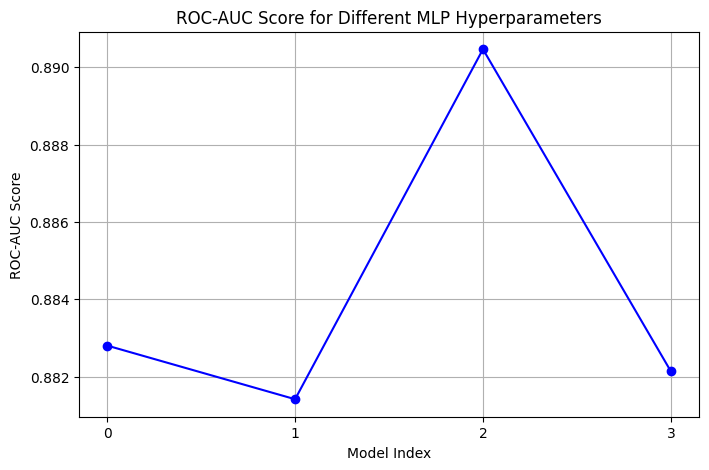


Hyperparameter tuning complete. Models and results saved.


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LayerNormalization, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import joblib
import json

# Enable mixed precision
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Set paths
data_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/data.xlsx"
save_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/mlp_hyperparameter_tuning"
os.makedirs(save_path, exist_ok=True)

# Load dataset
df = pd.read_excel(data_path).dropna()

def parse_vector(vector_str, expected_dim=768):
    if isinstance(vector_str, str):
        try:
            vec = np.array([float(i) for i in vector_str.strip("[]").split()], dtype=np.float32)
            return np.pad(vec, (0, max(0, expected_dim - len(vec))))[:expected_dim]
        except ValueError:
            pass
    return np.zeros(expected_dim, dtype=np.float32)

# Define embedding dimension
embedding_dim = 768

# Convert embeddings into arrays
embedding_features = ['word2vec_vector', 'fasttext_vector', 'sentence_embedding', 'sinbert_vector']
for feature in embedding_features:
    df[feature] = df[feature].map(lambda x: parse_vector(x, embedding_dim))

# Stack feature vectors efficiently
X = np.stack(df[embedding_features].apply(lambda row: np.column_stack(row.values), axis=1).values)
X_flattened = X.reshape(X.shape[0], -1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'].values)
joblib.dump(label_encoder, os.path.join(save_path, 'label_encoder.pkl'))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Define function to build MLP model
def build_mlp(input_shape, layer_sizes, dropout_rates, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    for size, dropout in zip(layer_sizes, dropout_rates):
        model.add(Dense(size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter combinations
hyperparams = [
    {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005},
    {'layer_sizes': [512, 256], 'dropout_rates': [0.3, 0.2], 'learning_rate': 0.001},
    {'layer_sizes': [256, 128, 64], 'dropout_rates': [0.3, 0.2, 0.1], 'learning_rate': 0.0003},
    {'layer_sizes': [128, 64], 'dropout_rates': [0.2, 0.1], 'learning_rate': 0.001},
]

results = {}
roc_values = []

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

for i, params in enumerate(hyperparams):
    print(f"\nTraining MLP Model with Hyperparameters: {params}")
    model = build_mlp((X_train.shape[1],), **params)
    history = model.fit(
        X_train, y_train,
        epochs=50, batch_size=32, validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr], verbose=1
    )
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    roc_values.append(roc_auc)

    model.save(os.path.join(save_path, f"MLP_model_{i}.keras"))
    results[f"Model_{i}"] = {"roc_auc": roc_auc, "params": params}
    print(f"ROC-AUC for Model {i}: {roc_auc:.4f}")

# Save results
with open(os.path.join(save_path, "mlp_results.json"), "w") as f:
    json.dump(results, f, indent=4)

# Plot ROC-AUC values
plt.figure(figsize=(8, 5))
plt.plot(range(len(hyperparams)), roc_values, marker='o', linestyle='-', color='b')
plt.xlabel('Model Index')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Score for Different MLP Hyperparameters')
plt.xticks(range(len(hyperparams)))
plt.grid()
plt.savefig(os.path.join(save_path, "mlp_roc_auc_plot.png"))
plt.show()

print("\nHyperparameter tuning complete. Models and results saved.")



Training MLP Model with Hyperparameters: {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7194 - loss: 0.5848 - val_accuracy: 0.6542 - val_loss: 0.5686 - learning_rate: 5.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7936 - loss: 0.4561 - val_accuracy: 0.7550 - val_loss: 0.4856 - learning_rate: 5.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8155 - loss: 0.4122 - val_accuracy: 0.7994 - val_loss: 0.4423 - learning_rate: 5.0000e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8178 - loss: 0.3854 - val_accuracy: 0.8095 - val_loss: 0.4513 - learning_rate: 5.0000e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8252 - loss: 0.3792 - val_accuracy: 0.8145 - val_loss: 0.4386 - learning_rate: 5.0000e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8264 - loss: 0

ROC-AUC for Model 0: 0.8822, F1 Score: 0.7899

Training MLP Model with Hyperparameters: {'layer_sizes': [512, 256], 'dropout_rates': [0.3, 0.2], 'learning_rate': 0.001}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7645 - loss: 0.5813 - val_accuracy: 0.7974 - val_loss: 0.4687 - learning_rate: 0.0010
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8228 - loss: 0.3925 - val_accuracy: 0.7883 - val_loss: 0.4724 - learning_rate: 0.0010
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8303 - loss: 0.3802 - val_accuracy: 0.8054 - val_loss: 0.4482 - learning_rate: 0.0010
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8431 - loss: 0.3503 - val_accuracy: 0.8054 - val_loss: 0.4669 - learning_rate: 0.0010
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8526 - loss: 0.3326 - val_accuracy: 0.8024 - val_loss: 0.5028 - learning_rate: 0.0010
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0

ROC-AUC for Model 1: 0.8790, F1 Score: 0.7711

Training MLP Model with Hyperparameters: {'layer_sizes': [256, 128, 64], 'dropout_rates': [0.3, 0.2, 0.1], 'learning_rate': 0.0003}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6820 - loss: 0.6045 - val_accuracy: 0.7782 - val_loss: 0.5223 - learning_rate: 3.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7914 - loss: 0.4537 - val_accuracy: 0.7984 - val_loss: 0.4523 - learning_rate: 3.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8169 - loss: 0.4051 - val_accuracy: 0.7933 - val_loss: 0.4409 - learning_rate: 3.0000e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8146 - loss: 0.4065 - val_accuracy: 0.8044 - val_loss: 0.4399 - learning_rate: 3.0000e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8247 - loss: 0.3887 - val_accuracy: 0.7994 - val_loss: 0.4316 - learning_rate: 3.0000e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━

ROC-AUC for Model 2: 0.8864, F1 Score: 0.7968

Training MLP Model with Hyperparameters: {'layer_sizes': [128, 64], 'dropout_rates': [0.2, 0.1], 'learning_rate': 0.001}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7539 - loss: 0.5434 - val_accuracy: 0.7490 - val_loss: 0.5099 - learning_rate: 0.0010
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8213 - loss: 0.4022 - val_accuracy: 0.7732 - val_loss: 0.4681 - learning_rate: 0.0010
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8347 - loss: 0.3716 - val_accuracy: 0.8054 - val_loss: 0.4329 - learning_rate: 0.0010
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8469 - loss: 0.3467 - val_accuracy: 0.7853 - val_loss: 0.4764 - learning_rate: 0.0010
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8543 - loss: 0.3351 - val_accuracy: 0.8145 - val_loss: 0.4248 - learning_rate: 0.0010
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8637 

ROC-AUC for Model 3: 0.8874, F1 Score: 0.7946


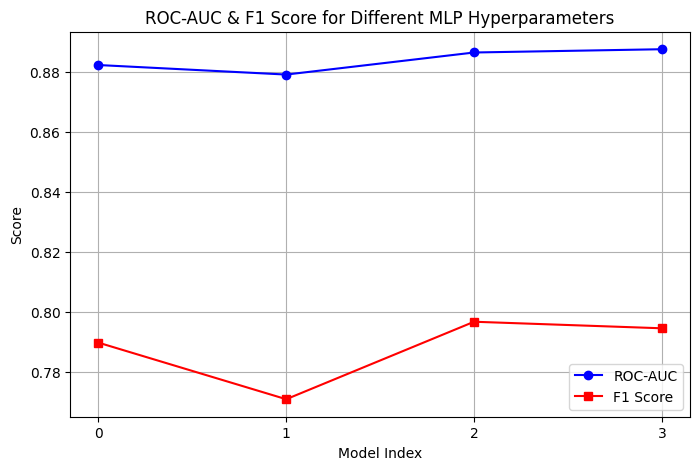


Hyperparameter tuning complete. Models and results saved.


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import joblib
import json

# Set paths
data_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/data.xlsx"
save_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/mlp_hyperparameter_tuningwithh5"
os.makedirs(save_path, exist_ok=True)

# Load dataset
df = pd.read_excel(data_path).dropna()

def parse_vector(vector_str, expected_dim=768):
    if isinstance(vector_str, str):
        try:
            vec = np.array([float(i) for i in vector_str.strip("[]").split()], dtype=np.float32)
            return np.pad(vec, (0, max(0, expected_dim - len(vec))))[:expected_dim]
        except ValueError:
            pass
    return np.zeros(expected_dim, dtype=np.float32)

# Define embedding dimension
embedding_dim = 768

# Convert embeddings into arrays
embedding_features = ['word2vec_vector', 'fasttext_vector', 'sentence_embedding', 'sinbert_vector']
for feature in embedding_features:
    df[feature] = df[feature].map(lambda x: parse_vector(x, embedding_dim))

# Stack feature vectors efficiently
X = np.stack(df[embedding_features].apply(lambda row: np.column_stack(row.values), axis=1).values)
X_flattened = X.reshape(X.shape[0], -1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'].values)
joblib.dump(label_encoder, os.path.join(save_path, 'label_encoder.pkl'))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Define function to build MLP model
def build_mlp(input_shape, layer_sizes, dropout_rates, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    for size, dropout in zip(layer_sizes, dropout_rates):
        model.add(Dense(size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter combinations
hyperparams = [
    {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005},
    {'layer_sizes': [512, 256], 'dropout_rates': [0.3, 0.2], 'learning_rate': 0.001},
    {'layer_sizes': [256, 128, 64], 'dropout_rates': [0.3, 0.2, 0.1], 'learning_rate': 0.0003},
    {'layer_sizes': [128, 64], 'dropout_rates': [0.2, 0.1], 'learning_rate': 0.001},
]

results = {}
roc_values = []
f1_values = []

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

for i, params in enumerate(hyperparams):
    print(f"\nTraining MLP Model with Hyperparameters: {params}")
    model = build_mlp((X_train.shape[1],), **params)
    history = model.fit(
        X_train, y_train,
        epochs=50, batch_size=32, validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr], verbose=1
    )
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    roc_auc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred)

    roc_values.append(roc_auc)
    f1_values.append(f1)

    model.save(os.path.join(save_path, f"MLP_model_{i}.keras"))
    model.save(os.path.join(save_path, f"MLP_model_{i}.h5"), save_format='h5')

    results[f"Model_{i}"] = {"roc_auc": roc_auc, "f1_score": f1, "params": params}
    print(f"ROC-AUC for Model {i}: {roc_auc:.4f}, F1 Score: {f1:.4f}")

# Save results
with open(os.path.join(save_path, "mlp_results.json"), "w") as f:
    json.dump(results, f, indent=4)

# Plot ROC-AUC and F1-score values
plt.figure(figsize=(8, 5))
plt.plot(range(len(hyperparams)), roc_values, marker='o', linestyle='-', color='b', label='ROC-AUC')
plt.plot(range(len(hyperparams)), f1_values, marker='s', linestyle='-', color='r', label='F1 Score')
plt.xlabel('Model Index')
plt.ylabel('Score')
plt.title('ROC-AUC & F1 Score for Different MLP Hyperparameters')
plt.xticks(range(len(hyperparams)))
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_path, "mlp_scores_plot.png"))
plt.show()

print("\nHyperparameter tuning complete. Models and results saved.")



Training MLP Model with Hyperparameters: {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7182 - loss: 0.5974 - val_accuracy: 0.7712 - val_loss: 0.5221 - learning_rate: 5.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7930 - loss: 0.4437 - val_accuracy: 0.8065 - val_loss: 0.4595 - learning_rate: 5.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8032 - loss: 0.4443 - val_accuracy: 0.8024 - val_loss: 0.4372 - learning_rate: 5.0000e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8242 - loss: 0.3911 - val_accuracy: 0.7933 - val_loss: 0.4421 - learning_rate: 5.0000e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8460 - loss: 0.3631 - val_accuracy: 0.8095 - val_loss: 0.4330 - learning_rate: 5.0000e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8353 - loss: 

ROC-AUC for Model 0: 0.8851, F1 Score: 0.7875

Training MLP Model with Hyperparameters: {'layer_sizes': [512, 256], 'dropout_rates': [0.3, 0.2], 'learning_rate': 0.001}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7362 - loss: 0.5892 - val_accuracy: 0.8014 - val_loss: 0.4691 - learning_rate: 0.0010
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8094 - loss: 0.4209 - val_accuracy: 0.8054 - val_loss: 0.4448 - learning_rate: 0.0010
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8255 - loss: 0.3880 - val_accuracy: 0.7520 - val_loss: 0.5172 - learning_rate: 0.0010
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8440 - loss: 0.3618 - val_accuracy: 0.7883 - val_loss: 0.4632 - learning_rate: 0.0010
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8452 - loss: 0.3413
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.

ROC-AUC for Model 1: 0.8829, F1 Score: 0.8004

Training MLP Model with Hyperparameters: {'layer_sizes': [256, 128, 64], 'dropout_rates': [0.3, 0.2, 0.1], 'learning_rate': 0.0003}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7176 - loss: 0.5933 - val_accuracy: 0.7087 - val_loss: 0.5493 - learning_rate: 3.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8060 - loss: 0.4373 - val_accuracy: 0.7944 - val_loss: 0.4598 - learning_rate: 3.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8137 - loss: 0.3953 - val_accuracy: 0.8004 - val_loss: 0.4444 - learning_rate: 3.0000e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8101 - loss: 0.4138 - val_accuracy: 0.7954 - val_loss: 0.4529 - learning_rate: 3.0000e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8207 - loss: 0.3877 - val_accuracy: 0.8044 - val_loss: 0.4503 - learning_rate: 3.0000e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━

ROC-AUC for Model 2: 0.8875, F1 Score: 0.8018

Training MLP Model with Hyperparameters: {'layer_sizes': [128, 64], 'dropout_rates': [0.2, 0.1], 'learning_rate': 0.001}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7513 - loss: 0.5374 - val_accuracy: 0.7399 - val_loss: 0.5351 - learning_rate: 0.0010
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8156 - loss: 0.4286 - val_accuracy: 0.7127 - val_loss: 0.5494 - learning_rate: 0.0010
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8147 - loss: 0.3942 - val_accuracy: 0.8054 - val_loss: 0.4375 - learning_rate: 0.0010
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8350 - loss: 0.3735 - val_accuracy: 0.7984 - val_loss: 0.4789 - learning_rate: 0.0010
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8553 - loss: 0.3360 - val_accuracy: 0.7913 - val_loss: 0.4634 - learning_rate: 0.0010
Epoch 6/50
118/124 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8434

ROC-AUC for Model 3: 0.8881, F1 Score: 0.7978


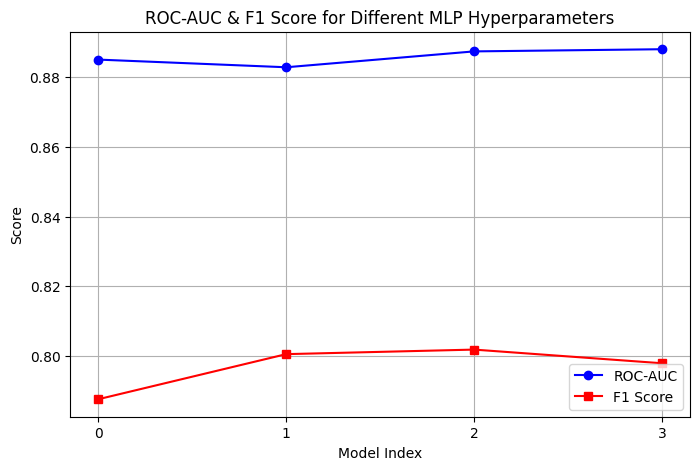


Hyperparameter tuning complete. Models and results saved.


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import joblib
import json

# Set paths
data_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/data.xlsx"
save_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/mlp_hyperparameter_tuningwithh5_2"
os.makedirs(save_path, exist_ok=True)

# Load dataset
df = pd.read_excel(data_path).dropna()

def parse_vector(vector_str, expected_dim=768):
    if isinstance(vector_str, str):
        try:
            vec = np.array([float(i) for i in vector_str.strip("[]").split()], dtype=np.float32)
            return np.pad(vec, (0, max(0, expected_dim - len(vec))))[:expected_dim]
        except ValueError:
            pass
    return np.zeros(expected_dim, dtype=np.float32)

# Define embedding dimension
embedding_dim = 768

# Convert embeddings into arrays
embedding_features = ['word2vec_vector', 'fasttext_vector', 'sentence_embedding', 'sinbert_vector']
for feature in embedding_features:
    df[feature] = df[feature].map(lambda x: parse_vector(x, embedding_dim))

# Stack feature vectors efficiently
X = np.stack(df[embedding_features].apply(lambda row: np.column_stack(row.values), axis=1).values)
X_flattened = X.reshape(X.shape[0], -1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'].values)
joblib.dump(label_encoder, os.path.join(save_path, 'label_encoder.pkl'))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Define function to build MLP model
def build_mlp(input_shape, layer_sizes, dropout_rates, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    for size, dropout in zip(layer_sizes, dropout_rates):
        model.add(Dense(size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter combinations
hyperparams = [
    {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005},
    {'layer_sizes': [512, 256], 'dropout_rates': [0.3, 0.2], 'learning_rate': 0.001},
    {'layer_sizes': [256, 128, 64], 'dropout_rates': [0.3, 0.2, 0.1], 'learning_rate': 0.0003},
    {'layer_sizes': [128, 64], 'dropout_rates': [0.2, 0.1], 'learning_rate': 0.001},
]

results = {}
roc_values = []
f1_values = []

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

for i, params in enumerate(hyperparams):
    print(f"\nTraining MLP Model with Hyperparameters: {params}")
    model = build_mlp((X_train.shape[1],), **params)
    history = model.fit(
        X_train, y_train,
        epochs=50, batch_size=32, validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr], verbose=1
    )
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    roc_auc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred)

    roc_values.append(roc_auc)
    f1_values.append(f1)

    model.save(os.path.join(save_path, f"MLP_model_{i}.keras"))
    model.save(os.path.join(save_path, f"MLP_model_{i}.h5"), save_format='h5')

    results[f"Model_{i}"] = {"roc_auc": roc_auc, "f1_score": f1, "params": params}
    print(f"ROC-AUC for Model {i}: {roc_auc:.4f}, F1 Score: {f1:.4f}")

# Save results
with open(os.path.join(save_path, "mlp_results.json"), "w") as f:
    json.dump(results, f, indent=4)

# Plot ROC-AUC and F1-score values
plt.figure(figsize=(8, 5))
plt.plot(range(len(hyperparams)), roc_values, marker='o', linestyle='-', color='b', label='ROC-AUC')
plt.plot(range(len(hyperparams)), f1_values, marker='s', linestyle='-', color='r', label='F1 Score')
plt.xlabel('Model Index')
plt.ylabel('Score')
plt.title('ROC-AUC & F1 Score for Different MLP Hyperparameters')
plt.xticks(range(len(hyperparams)))
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_path, "mlp_scores_plot.png"))
plt.show()

print("\nHyperparameter tuning complete. Models and results saved.")


Training MLP Model with Hyperparameters: {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.7164 - loss: 0.6014 - val_accuracy: 0.7238 - val_loss: 0.5319 - learning_rate: 5.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7932 - loss: 0.4525 - val_accuracy: 0.8044 - val_loss: 0.4321 - learning_rate: 5.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7979 - loss: 0.4431 - val_accuracy: 0.8065 - val_loss: 0.4378 - learning_rate: 5.0000e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8139 - loss: 0.4075 - val_accuracy: 0.7984 - val_loss: 0.4511 - learning_rate: 5.0000e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8285 - loss: 0.3775
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8284 - loss: 0.3776

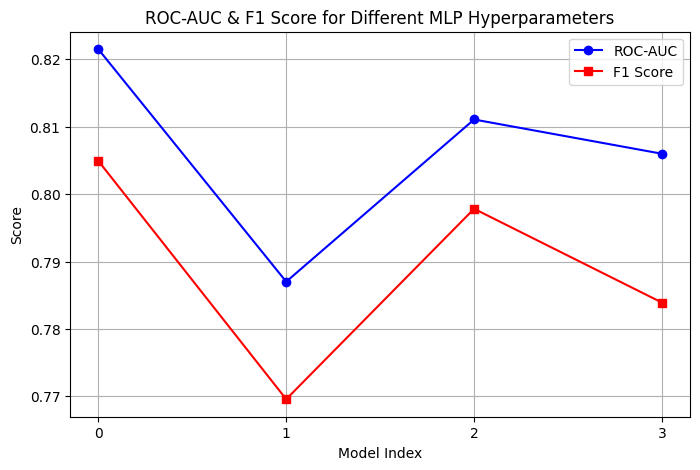


Hyperparameter tuning complete. Models and results saved.


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import joblib
import json

# Set paths
data_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/data.xlsx"
save_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/mlp_hyperparameter_tuning2"
os.makedirs(save_path, exist_ok=True)
os.makedirs(save_path, exist_ok=True)

# Load dataset
df = pd.read_excel(data_path).dropna()

def parse_vector(vector_str, expected_dim=768):
    if isinstance(vector_str, str):
        try:
            vec = np.array([float(i) for i in vector_str.strip("[]").split()], dtype=np.float32)
            return np.pad(vec, (0, max(0, expected_dim - len(vec))))[:expected_dim]
        except ValueError:
            pass
    return np.zeros(expected_dim, dtype=np.float32)

# Define embedding dimension
embedding_dim = 768

# Convert embeddings into arrays
embedding_features = ['word2vec_vector', 'fasttext_vector', 'sentence_embedding', 'sinbert_vector']
for feature in embedding_features:
    df[feature] = df[feature].map(lambda x: parse_vector(x, embedding_dim))

# Stack feature vectors efficiently
X = np.stack(df[embedding_features].apply(lambda row: np.column_stack(row.values), axis=1).values)
X_flattened = X.reshape(X.shape[0], -1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'].values)
joblib.dump(label_encoder, os.path.join(save_path, 'label_encoder.pkl'))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Define function to build MLP model
def build_mlp(input_shape, layer_sizes, dropout_rates, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    for size, dropout in zip(layer_sizes, dropout_rates):
        model.add(Dense(size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter combinations
hyperparams = [
    {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005},
    {'layer_sizes': [512, 256], 'dropout_rates': [0.3, 0.2], 'learning_rate': 0.001},
    {'layer_sizes': [256, 128, 64], 'dropout_rates': [0.3, 0.2, 0.1], 'learning_rate': 0.0003},
    {'layer_sizes': [128, 64], 'dropout_rates': [0.2, 0.1], 'learning_rate': 0.001},
]

results = {}
roc_values = []
f1_values = []

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

for i, params in enumerate(hyperparams):
    print(f"\nTraining MLP Model with Hyperparameters: {params}")
    model = build_mlp((X_train.shape[1],), **params)
    history = model.fit(
        X_train, y_train,
        epochs=50, batch_size=32, validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr], verbose=1
    )
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    roc_values.append(roc_auc)
    f1_values.append(f1)

    model.save(os.path.join(save_path, f"MLP_model_{i}.keras"))
    results[f"Model_{i}"] = {"roc_auc": roc_auc, "f1_score": f1, "params": params}
    print(f"ROC-AUC for Model {i}: {roc_auc:.4f}, F1 Score: {f1:.4f}")

# Save results
with open(os.path.join(save_path, "mlp_results.json"), "w") as f:
    json.dump(results, f, indent=4)

# Plot ROC-AUC and F1-score values
plt.figure(figsize=(8, 5))
plt.plot(range(len(hyperparams)), roc_values, marker='o', linestyle='-', color='b', label='ROC-AUC')
plt.plot(range(len(hyperparams)), f1_values, marker='s', linestyle='-', color='r', label='F1 Score')
plt.xlabel('Model Index')
plt.ylabel('Score')
plt.title('ROC-AUC & F1 Score for Different MLP Hyperparameters')
plt.xticks(range(len(hyperparams)))
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_path, "mlp_scores_plot.png"))
plt.show()

print("\nHyperparameter tuning complete. Models and results saved.")



Training MLP Model with Hyperparameters: {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7282 - loss: 0.5892 - val_accuracy: 0.7692 - val_loss: 0.5261 - learning_rate: 5.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7929 - loss: 0.4560 - val_accuracy: 0.8105 - val_loss: 0.4439 - learning_rate: 5.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7942 - loss: 0.4399 - val_accuracy: 0.8155 - val_loss: 0.4473 - learning_rate: 5.0000e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8285 - loss: 0.3930 - val_accuracy: 0.8054 - val_loss: 0.4416 - learning_rate: 5.0000e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8207 - loss: 0.4057 - val_accuracy: 0.8044 - val_loss: 0.4587 - learning_rate: 5.0000e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8326 - loss: 0

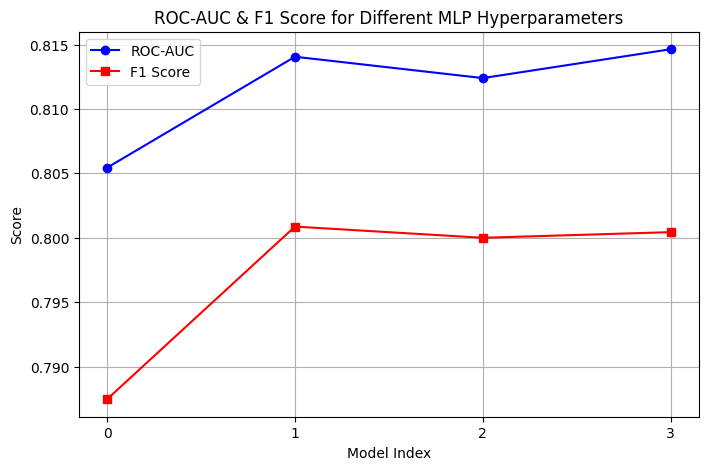


Hyperparameter tuning complete. Models and results saved.


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import joblib
import json

# Set paths
data_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/data.xlsx"
save_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/mlp_hyperparameter_tuning1_3"
os.makedirs(save_path, exist_ok=True)
os.makedirs(save_path, exist_ok=True)

# Load dataset
df = pd.read_excel(data_path).dropna()

def parse_vector(vector_str, expected_dim=768):
    if isinstance(vector_str, str):
        try:
            vec = np.array([float(i) for i in vector_str.strip("[]").split()], dtype=np.float32)
            return np.pad(vec, (0, max(0, expected_dim - len(vec))))[:expected_dim]
        except ValueError:
            pass
    return np.zeros(expected_dim, dtype=np.float32)

# Define embedding dimension
embedding_dim = 768

# Convert embeddings into arrays
embedding_features = ['word2vec_vector', 'fasttext_vector', 'sentence_embedding', 'sinbert_vector']
for feature in embedding_features:
    df[feature] = df[feature].map(lambda x: parse_vector(x, embedding_dim))

# Stack feature vectors efficiently
X = np.stack(df[embedding_features].apply(lambda row: np.column_stack(row.values), axis=1).values)
X_flattened = X.reshape(X.shape[0], -1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'].values)
joblib.dump(label_encoder, os.path.join(save_path, 'label_encoder.pkl'))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Define function to build MLP model
def build_mlp(input_shape, layer_sizes, dropout_rates, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    for size, dropout in zip(layer_sizes, dropout_rates):
        model.add(Dense(size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter combinations
hyperparams = [
    {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005},
    {'layer_sizes': [512, 256], 'dropout_rates': [0.3, 0.2], 'learning_rate': 0.001},
    {'layer_sizes': [256, 128, 64], 'dropout_rates': [0.3, 0.2, 0.1], 'learning_rate': 0.0003},
    {'layer_sizes': [128, 64], 'dropout_rates': [0.2, 0.1], 'learning_rate': 0.001},
]

results = {}
roc_values = []
f1_values = []

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

for i, params in enumerate(hyperparams):
    print(f"\nTraining MLP Model with Hyperparameters: {params}")
    model = build_mlp((X_train.shape[1],), **params)
    history = model.fit(
        X_train, y_train,
        epochs=50, batch_size=32, validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr], verbose=1
    )
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    roc_values.append(roc_auc)
    f1_values.append(f1)

    model.save(os.path.join(save_path, f"MLP_model_{i}.keras"))
    results[f"Model_{i}"] = {"roc_auc": roc_auc, "f1_score": f1, "params": params}
    print(f"ROC-AUC for Model {i}: {roc_auc:.4f}, F1 Score: {f1:.4f}")

# Save results
with open(os.path.join(save_path, "mlp_results.json"), "w") as f:
    json.dump(results, f, indent=4)

# Plot ROC-AUC and F1-score values
plt.figure(figsize=(8, 5))
plt.plot(range(len(hyperparams)), roc_values, marker='o', linestyle='-', color='b', label='ROC-AUC')
plt.plot(range(len(hyperparams)), f1_values, marker='s', linestyle='-', color='r', label='F1 Score')
plt.xlabel('Model Index')
plt.ylabel('Score')
plt.title('ROC-AUC & F1 Score for Different MLP Hyperparameters')
plt.xticks(range(len(hyperparams)))
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_path, "mlp_scores_plot.png"))
plt.show()

print("\nHyperparameter tuning complete. Models and results saved.")


Training MLP Model with Hyperparameters: {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7319 - loss: 0.5904 - val_accuracy: 0.7913 - val_loss: 0.4957 - learning_rate: 5.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7828 - loss: 0.4699 - val_accuracy: 0.8095 - val_loss: 0.4451 - learning_rate: 5.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7888 - loss: 0.4427 - val_accuracy: 0.8175 - val_loss: 0.4384 - learning_rate: 5.0000e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8284 - loss: 0.3956 - val_accuracy: 0.8034 - val_loss: 0.4344 - learning_rate: 5.0000e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8410 - loss: 0.3598 - val_accuracy: 0.7964 - val_loss: 0.4529 - learning_rate: 5.0000e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8321 - loss: 0

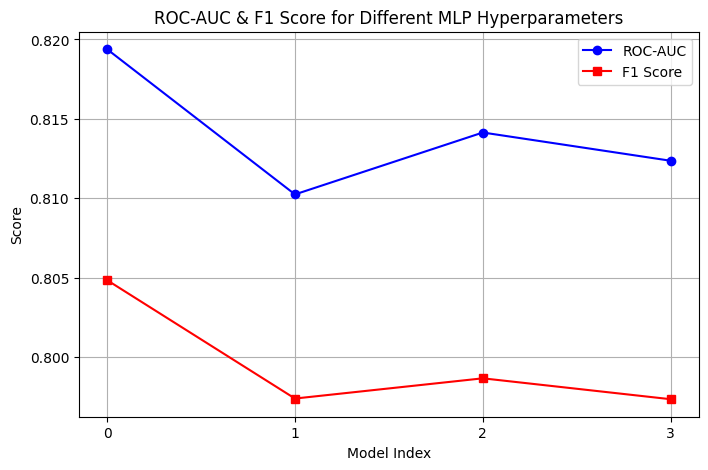


Hyperparameter tuning complete. Models and results saved.


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import joblib
import json

# Set paths
data_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/data.xlsx"
save_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/mlp_hyperparameter_tuning1_4"
os.makedirs(save_path, exist_ok=True)
os.makedirs(save_path, exist_ok=True)

# Load dataset
df = pd.read_excel(data_path).dropna()

def parse_vector(vector_str, expected_dim=768):
    if isinstance(vector_str, str):
        try:
            vec = np.array([float(i) for i in vector_str.strip("[]").split()], dtype=np.float32)
            return np.pad(vec, (0, max(0, expected_dim - len(vec))))[:expected_dim]
        except ValueError:
            pass
    return np.zeros(expected_dim, dtype=np.float32)

# Define embedding dimension
embedding_dim = 768

# Convert embeddings into arrays
embedding_features = ['word2vec_vector', 'fasttext_vector', 'sentence_embedding', 'sinbert_vector']
for feature in embedding_features:
    df[feature] = df[feature].map(lambda x: parse_vector(x, embedding_dim))

# Stack feature vectors efficiently
X = np.stack(df[embedding_features].apply(lambda row: np.column_stack(row.values), axis=1).values)
X_flattened = X.reshape(X.shape[0], -1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'].values)
joblib.dump(label_encoder, os.path.join(save_path, 'label_encoder.pkl'))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Define function to build MLP model
def build_mlp(input_shape, layer_sizes, dropout_rates, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    for size, dropout in zip(layer_sizes, dropout_rates):
        model.add(Dense(size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter combinations
hyperparams = [
    {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005},
    {'layer_sizes': [512, 256], 'dropout_rates': [0.3, 0.2], 'learning_rate': 0.001},
    {'layer_sizes': [256, 128, 64], 'dropout_rates': [0.3, 0.2, 0.1], 'learning_rate': 0.0003},
    {'layer_sizes': [128, 64], 'dropout_rates': [0.2, 0.1], 'learning_rate': 0.001},
]

results = {}
roc_values = []
f1_values = []

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

for i, params in enumerate(hyperparams):
    print(f"\nTraining MLP Model with Hyperparameters: {params}")
    model = build_mlp((X_train.shape[1],), **params)
    history = model.fit(
        X_train, y_train,
        epochs=50, batch_size=32, validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr], verbose=1
    )
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    roc_values.append(roc_auc)
    f1_values.append(f1)

    model.save(os.path.join(save_path, f"MLP_model_{i}.keras"))
    results[f"Model_{i}"] = {"roc_auc": roc_auc, "f1_score": f1, "params": params}
    print(f"ROC-AUC for Model {i}: {roc_auc:.4f}, F1 Score: {f1:.4f}")

# Save results
with open(os.path.join(save_path, "mlp_results.json"), "w") as f:
    json.dump(results, f, indent=4)

# Plot ROC-AUC and F1-score values
plt.figure(figsize=(8, 5))
plt.plot(range(len(hyperparams)), roc_values, marker='o', linestyle='-', color='b', label='ROC-AUC')
plt.plot(range(len(hyperparams)), f1_values, marker='s', linestyle='-', color='r', label='F1 Score')
plt.xlabel('Model Index')
plt.ylabel('Score')
plt.title('ROC-AUC & F1 Score for Different MLP Hyperparameters')
plt.xticks(range(len(hyperparams)))
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_path, "mlp_scores_plot.png"))
plt.show()

print("\nHyperparameter tuning complete. Models and results saved.")


Training MLP Model with Hyperparameters: {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7161 - loss: 0.5900 - val_accuracy: 0.7984 - val_loss: 0.4967 - learning_rate: 5.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7896 - loss: 0.4481 - val_accuracy: 0.8085 - val_loss: 0.4441 - learning_rate: 5.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8118 - loss: 0.4126 - val_accuracy: 0.7933 - val_loss: 0.4597 - learning_rate: 5.0000e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8143 - loss: 0.4050 - val_accuracy: 0.8085 - val_loss: 0.4402 - learning_rate: 5.0000e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8236 - loss: 0.3813 - val_accuracy: 0.7933 - val_loss: 0.4451 - learning_rate: 5.0000e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8330 - loss: 0

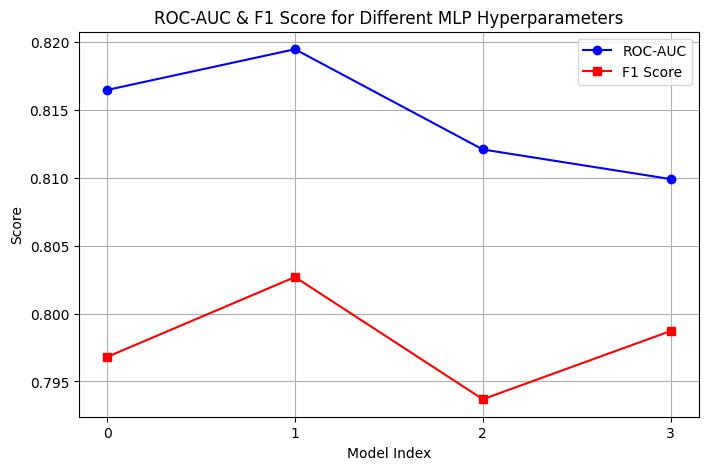


Hyperparameter tuning complete. Models and results saved.


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import joblib
import json

# Set paths
data_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/data.xlsx"
save_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/mlp_hyperparameter_tuning1_5"
os.makedirs(save_path, exist_ok=True)
os.makedirs(save_path, exist_ok=True)

# Load dataset
df = pd.read_excel(data_path).dropna()

def parse_vector(vector_str, expected_dim=768):
    if isinstance(vector_str, str):
        try:
            vec = np.array([float(i) for i in vector_str.strip("[]").split()], dtype=np.float32)
            return np.pad(vec, (0, max(0, expected_dim - len(vec))))[:expected_dim]
        except ValueError:
            pass
    return np.zeros(expected_dim, dtype=np.float32)

# Define embedding dimension
embedding_dim = 768

# Convert embeddings into arrays
embedding_features = ['word2vec_vector', 'fasttext_vector', 'sentence_embedding', 'sinbert_vector']
for feature in embedding_features:
    df[feature] = df[feature].map(lambda x: parse_vector(x, embedding_dim))

# Stack feature vectors efficiently
X = np.stack(df[embedding_features].apply(lambda row: np.column_stack(row.values), axis=1).values)
X_flattened = X.reshape(X.shape[0], -1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'].values)
joblib.dump(label_encoder, os.path.join(save_path, 'label_encoder.pkl'))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Define function to build MLP model
def build_mlp(input_shape, layer_sizes, dropout_rates, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    for size, dropout in zip(layer_sizes, dropout_rates):
        model.add(Dense(size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter combinations
hyperparams = [
    {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005},
    {'layer_sizes': [512, 256], 'dropout_rates': [0.3, 0.2], 'learning_rate': 0.001},
    {'layer_sizes': [256, 128, 64], 'dropout_rates': [0.3, 0.2, 0.1], 'learning_rate': 0.0003},
    {'layer_sizes': [128, 64], 'dropout_rates': [0.2, 0.1], 'learning_rate': 0.001},
]

results = {}
roc_values = []
f1_values = []

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

for i, params in enumerate(hyperparams):
    print(f"\nTraining MLP Model with Hyperparameters: {params}")
    model = build_mlp((X_train.shape[1],), **params)
    history = model.fit(
        X_train, y_train,
        epochs=50, batch_size=32, validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr], verbose=1
    )
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    roc_values.append(roc_auc)
    f1_values.append(f1)

    model.save(os.path.join(save_path, f"MLP_model_{i}.keras"))
    results[f"Model_{i}"] = {"roc_auc": roc_auc, "f1_score": f1, "params": params}
    print(f"ROC-AUC for Model {i}: {roc_auc:.4f}, F1 Score: {f1:.4f}")

# Save results
with open(os.path.join(save_path, "mlp_results.json"), "w") as f:
    json.dump(results, f, indent=4)

# Plot ROC-AUC and F1-score values
plt.figure(figsize=(8, 5))
plt.plot(range(len(hyperparams)), roc_values, marker='o', linestyle='-', color='b', label='ROC-AUC')
plt.plot(range(len(hyperparams)), f1_values, marker='s', linestyle='-', color='r', label='F1 Score')
plt.xlabel('Model Index')
plt.ylabel('Score')
plt.title('ROC-AUC & F1 Score for Different MLP Hyperparameters')
plt.xticks(range(len(hyperparams)))
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_path, "mlp_scores_plot.png"))
plt.show()

print("\nHyperparameter tuning complete. Models and results saved.")


Training MLP Model with Hyperparameters: {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7164 - loss: 0.6089 - val_accuracy: 0.7520 - val_loss: 0.5159 - learning_rate: 5.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8020 - loss: 0.4491 - val_accuracy: 0.7944 - val_loss: 0.4545 - learning_rate: 5.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8044 - loss: 0.4211 - val_accuracy: 0.8155 - val_loss: 0.4340 - learning_rate: 5.0000e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8091 - loss: 0.4177 - val_accuracy: 0.8145 - val_loss: 0.4227 - learning_rate: 5.0000e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8243 - loss: 0.4058 - val_accuracy: 0.7903 - val_loss: 0.4685 - learning_rate: 5.0000e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8265 - loss: 0

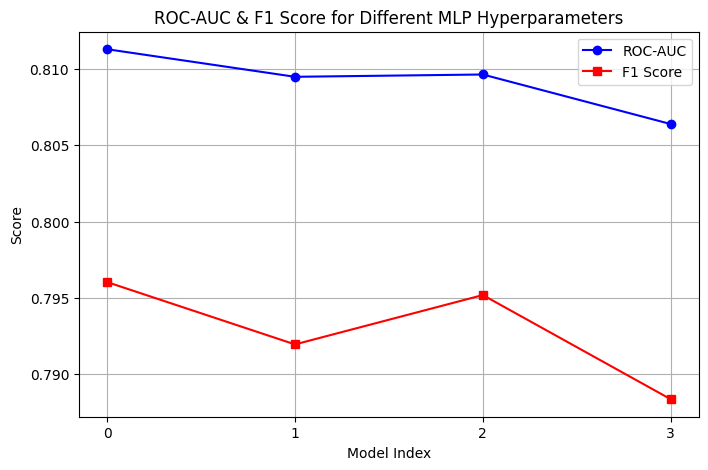


Hyperparameter tuning complete. Models and results saved.


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import joblib
import json

# Set paths
data_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/data.xlsx"
save_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/mlp_hyperparameter_tuning1_6"
os.makedirs(save_path, exist_ok=True)
os.makedirs(save_path, exist_ok=True)

# Load dataset
df = pd.read_excel(data_path).dropna()

def parse_vector(vector_str, expected_dim=768):
    if isinstance(vector_str, str):
        try:
            vec = np.array([float(i) for i in vector_str.strip("[]").split()], dtype=np.float32)
            return np.pad(vec, (0, max(0, expected_dim - len(vec))))[:expected_dim]
        except ValueError:
            pass
    return np.zeros(expected_dim, dtype=np.float32)

# Define embedding dimension
embedding_dim = 768

# Convert embeddings into arrays
embedding_features = ['word2vec_vector', 'fasttext_vector', 'sentence_embedding', 'sinbert_vector']
for feature in embedding_features:
    df[feature] = df[feature].map(lambda x: parse_vector(x, embedding_dim))

# Stack feature vectors efficiently
X = np.stack(df[embedding_features].apply(lambda row: np.column_stack(row.values), axis=1).values)
X_flattened = X.reshape(X.shape[0], -1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'].values)
joblib.dump(label_encoder, os.path.join(save_path, 'label_encoder.pkl'))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Define function to build MLP model
def build_mlp(input_shape, layer_sizes, dropout_rates, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    for size, dropout in zip(layer_sizes, dropout_rates):
        model.add(Dense(size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter combinations
hyperparams = [
    {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2], 'learning_rate': 0.0005},
    {'layer_sizes': [512, 256], 'dropout_rates': [0.3, 0.2], 'learning_rate': 0.001},
    {'layer_sizes': [256, 128, 64], 'dropout_rates': [0.3, 0.2, 0.1], 'learning_rate': 0.0003},
    {'layer_sizes': [128, 64], 'dropout_rates': [0.2, 0.1], 'learning_rate': 0.001},
]

results = {}
roc_values = []
f1_values = []

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

for i, params in enumerate(hyperparams):
    print(f"\nTraining MLP Model with Hyperparameters: {params}")
    model = build_mlp((X_train.shape[1],), **params)
    history = model.fit(
        X_train, y_train,
        epochs=50, batch_size=32, validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr], verbose=1
    )
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    roc_values.append(roc_auc)
    f1_values.append(f1)

    model.save(os.path.join(save_path, f"MLP_model_{i}.keras"))
    results[f"Model_{i}"] = {"roc_auc": roc_auc, "f1_score": f1, "params": params}
    print(f"ROC-AUC for Model {i}: {roc_auc:.4f}, F1 Score: {f1:.4f}")

# Save results
with open(os.path.join(save_path, "mlp_results.json"), "w") as f:
    json.dump(results, f, indent=4)

# Plot ROC-AUC and F1-score values
plt.figure(figsize=(8, 5))
plt.plot(range(len(hyperparams)), roc_values, marker='o', linestyle='-', color='b', label='ROC-AUC')
plt.plot(range(len(hyperparams)), f1_values, marker='s', linestyle='-', color='r', label='F1 Score')
plt.xlabel('Model Index')
plt.ylabel('Score')
plt.title('ROC-AUC & F1 Score for Different MLP Hyperparameters')
plt.xticks(range(len(hyperparams)))
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_path, "mlp_scores_plot.png"))
plt.show()

print("\nHyperparameter tuning complete. Models and results saved.")


Training MLP Model with Hyperparameters: {'layer_sizes': [512, 256, 128, 64], 'dropout_rates': [0.4, 0.3, 0.2, 0.1], 'learning_rate': 0.0005}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.6168 - loss: 0.7073 - val_accuracy: 0.7500 - val_loss: 0.5820 - learning_rate: 5.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7642 - loss: 0.5061 - val_accuracy: 0.7762 - val_loss: 0.4723 - learning_rate: 5.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7766 - loss: 0.4703 - val_accuracy: 0.7923 - val_loss: 0.4465 - learning_rate: 5.0000e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.7978 - loss: 0.4426 - val_accuracy: 0.7994 - val_loss: 0.4410 - learning_rate: 5.0000e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8060 - loss: 0.4290 - val_accuracy: 0.8004 - val_loss: 0.4459 - learning_rate: 5.0000e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8154

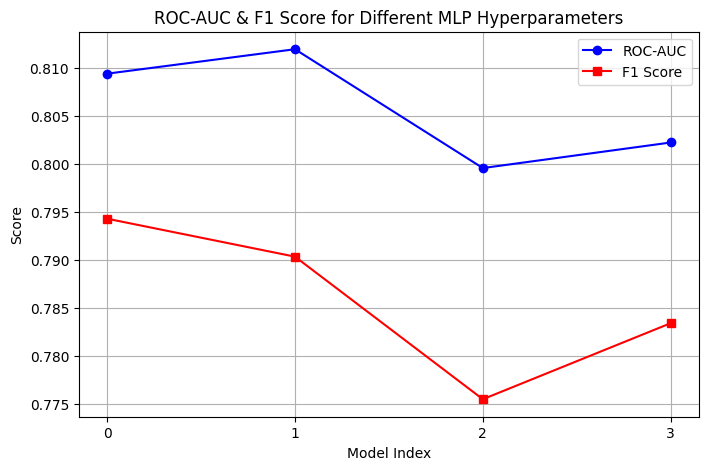


Hyperparameter tuning complete. Models and results saved.


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import joblib
import json

# Set paths
data_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/data.xlsx"
save_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/mlp_hyperparameter_tuning2"
os.makedirs(save_path, exist_ok=True)

# Load dataset
df = pd.read_excel(data_path).dropna()

def parse_vector(vector_str, expected_dim=768):
    if isinstance(vector_str, str):
        try:
            vec = np.array([float(i) for i in vector_str.strip("[]").split()], dtype=np.float32)
            return np.pad(vec, (0, max(0, expected_dim - len(vec))))[:expected_dim]
        except ValueError:
            pass
    return np.zeros(expected_dim, dtype=np.float32)

# Define embedding dimension
embedding_dim = 768

# Convert embeddings into arrays
embedding_features = ['word2vec_vector', 'fasttext_vector', 'sentence_embedding', 'sinbert_vector']
for feature in embedding_features:
    df[feature] = df[feature].map(lambda x: parse_vector(x, embedding_dim))

# Stack feature vectors efficiently
X = np.stack(df[embedding_features].apply(lambda row: np.column_stack(row.values), axis=1).values)
X_flattened = X.reshape(X.shape[0], -1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'].values)
joblib.dump(label_encoder, os.path.join(save_path, 'label_encoder.pkl'))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Define function to build MLP model
def build_mlp(input_shape, layer_sizes, dropout_rates, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    for size, dropout in zip(layer_sizes, dropout_rates):
        model.add(Dense(size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter combinations
hyperparams = [
    {'layer_sizes': [512, 256, 128, 64], 'dropout_rates': [0.4, 0.3, 0.2, 0.1], 'learning_rate': 0.0005},
    {'layer_sizes': [512, 256, 128], 'dropout_rates': [0.3, 0.2, 0.1], 'learning_rate': 0.001},
    {'layer_sizes': [256, 128, 64, 32], 'dropout_rates': [0.3, 0.2, 0.1, 0.1], 'learning_rate': 0.0003},
    {'layer_sizes': [128, 64, 32], 'dropout_rates': [0.2, 0.1, 0.1], 'learning_rate': 0.001},
]

results = {}
roc_values = []
f1_values = []

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

for i, params in enumerate(hyperparams):
    print(f"\nTraining MLP Model with Hyperparameters: {params}")
    model = build_mlp((X_train.shape[1],), **params)
    history = model.fit(
        X_train, y_train,
        epochs=50, batch_size=32, validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr], verbose=1
    )
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    roc_values.append(roc_auc)
    f1_values.append(f1)

    model.save(os.path.join(save_path, f"MLP_model_{i}.keras"))
    results[f"Model_{i}"] = {"roc_auc": roc_auc, "f1_score": f1, "params": params}
    print(f"ROC-AUC for Model {i}: {roc_auc:.4f}, F1 Score: {f1:.4f}")

# Save results
with open(os.path.join(save_path, "mlp_results.json"), "w") as f:
    json.dump(results, f, indent=4)

# Plot ROC-AUC and F1-score values
plt.figure(figsize=(8, 5))
plt.plot(range(len(hyperparams)), roc_values, marker='o', linestyle='-', color='b', label='ROC-AUC')
plt.plot(range(len(hyperparams)), f1_values, marker='s', linestyle='-', color='r', label='F1 Score')
plt.xlabel('Model Index')
plt.ylabel('Score')
plt.title('ROC-AUC & F1 Score for Different MLP Hyperparameters')
plt.xticks(range(len(hyperparams)))
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_path, "mlp_scores_plot.png"))
plt.show()

print("\nHyperparameter tuning complete. Models and results saved.")



Training MLP Model with Hyperparameters: {'layer_sizes': [1024, 512, 256, 128, 64], 'dropout_rates': [0.5, 0.4, 0.3, 0.2, 0.1], 'learning_rate': 0.0005}
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.5594 - loss: 0.7800 - val_accuracy: 0.5958 - val_loss: 0.6354 - learning_rate: 5.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.7069 - loss: 0.5812 - val_accuracy: 0.7681 - val_loss: 0.4811 - learning_rate: 5.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.7530 - loss: 0.5184 - val_accuracy: 0.7651 - val_loss: 0.4938 - learning_rate: 5.0000e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.7799 - loss: 0.4924 - val_accuracy: 0.7974 - val_loss: 0.4548 - learning_rate: 5.0000e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.7985 - loss: 0.4640 - val_accuracy: 0.7853 - val_loss: 0.4727 - learning_rate: 5.0000e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - ac

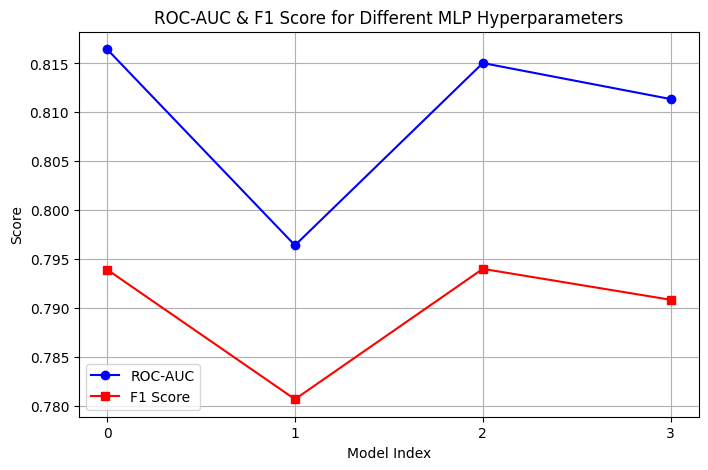


Hyperparameter tuning complete. Models and results saved.


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import joblib
import json

# Set paths
data_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/data.xlsx"
save_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/mlp_hyperparameter_tuning3"
os.makedirs(save_path, exist_ok=True)

# Load dataset
df = pd.read_excel(data_path).dropna()

def parse_vector(vector_str, expected_dim=768):
    if isinstance(vector_str, str):
        try:
            vec = np.array([float(i) for i in vector_str.strip("[]").split()], dtype=np.float32)
            return np.pad(vec, (0, max(0, expected_dim - len(vec))))[:expected_dim]
        except ValueError:
            pass
    return np.zeros(expected_dim, dtype=np.float32)

# Define embedding dimension
embedding_dim = 768

# Convert embeddings into arrays
embedding_features = ['word2vec_vector', 'fasttext_vector', 'sentence_embedding', 'sinbert_vector']
for feature in embedding_features:
    df[feature] = df[feature].map(lambda x: parse_vector(x, embedding_dim))

# Stack feature vectors efficiently
X = np.stack(df[embedding_features].apply(lambda row: np.column_stack(row.values), axis=1).values)
X_flattened = X.reshape(X.shape[0], -1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'].values)
joblib.dump(label_encoder, os.path.join(save_path, 'label_encoder.pkl'))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Define function to build MLP model
def build_mlp(input_shape, layer_sizes, dropout_rates, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    for size, dropout in zip(layer_sizes, dropout_rates):
        model.add(Dense(size, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter combinations
hyperparams = [
    {'layer_sizes': [1024, 512, 256, 128, 64], 'dropout_rates': [0.5, 0.4, 0.3, 0.2, 0.1], 'learning_rate': 0.0005},
    {'layer_sizes': [1024, 512, 256, 128], 'dropout_rates': [0.4, 0.3, 0.2, 0.1], 'learning_rate': 0.001},
    {'layer_sizes': [512, 256, 128, 64, 32], 'dropout_rates': [0.3, 0.2, 0.1, 0.1, 0.05], 'learning_rate': 0.0003},
    {'layer_sizes': [256, 128, 64, 32, 16], 'dropout_rates': [0.2, 0.1, 0.1, 0.05, 0.05], 'learning_rate': 0.001},
]

results = {}
roc_values = []
f1_values = []

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

for i, params in enumerate(hyperparams):
    print(f"\nTraining MLP Model with Hyperparameters: {params}")
    model = build_mlp((X_train.shape[1],), **params)
    history = model.fit(
        X_train, y_train,
        epochs=50, batch_size=32, validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr], verbose=1
    )
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    roc_values.append(roc_auc)
    f1_values.append(f1)

    model.save(os.path.join(save_path, f"MLP_model_{i}.keras"))
    results[f"Model_{i}"] = {"roc_auc": roc_auc, "f1_score": f1, "params": params}
    print(f"ROC-AUC for Model {i}: {roc_auc:.4f}, F1 Score: {f1:.4f}")

# Save results
with open(os.path.join(save_path, "mlp_results.json"), "w") as f:
    json.dump(results, f, indent=4)

# Plot ROC-AUC and F1-score values
plt.figure(figsize=(8, 5))
plt.plot(range(len(hyperparams)), roc_values, marker='o', linestyle='-', color='b', label='ROC-AUC')
plt.plot(range(len(hyperparams)), f1_values, marker='s', linestyle='-', color='r', label='F1 Score')
plt.xlabel('Model Index')
plt.ylabel('Score')
plt.title('ROC-AUC & F1 Score for Different MLP Hyperparameters')
plt.xticks(range(len(hyperparams)))
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_path, "mlp_scores_plot.png"))
plt.show()

print("\nHyperparameter tuning complete. Models and results saved.")


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import json

# ✅ Paths
model_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/MLP_model_2.keras"
config_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/config.json"
metadata_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/metadata.json"
label_encoder_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/label_encoder.pkl"
new_data_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/annotated_data.xlsx"
output_predictions_path = "/content/drive/MyDrive/data_set_emotion/Other_Emotion_Models/tested_models/DeepLearning/predictions.csv"

# ✅ Load Model
model = tf.keras.models.load_model(model_path)
print("✅ Model Loaded Successfully!")

# ✅ Load Label Encoder
label_encoder = joblib.load(label_encoder_path)

# ✅ Load and Preprocess New Data
df_new = pd.read_excel(new_data_path).dropna()

# ✅ Parsing Function
def parse_vector(vector_str, expected_dim=768):
    if isinstance(vector_str, str):
        try:
            vec = np.array([float(i) for i in vector_str.strip("[]").split()], dtype=np.float32)
            return np.pad(vec, (0, max(0, expected_dim - len(vec))))[:expected_dim]
        except ValueError:
            pass
    return np.zeros(expected_dim, dtype=np.float32)

# ✅ Convert embeddings into arrays
embedding_features = ['word2vec_vector', 'fasttext_vector', 'sentence_embedding', 'sinbert_vector']
for feature in embedding_features:
    df_new[feature] = df_new[feature].map(lambda x: parse_vector(x, 768))

# ✅ Stack feature vectors
X_new = np.stack(df_new[embedding_features].apply(lambda row: np.column_stack(row.values), axis=1).values)
X_new_flattened = X_new.reshape(X_new.shape[0], -1)

# ✅ Make Predictions
y_pred_prob = model.predict(X_new_flattened)  # Probability scores
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary labels

# ✅ Decode Predictions
df_new['predicted_label'] = label_encoder.inverse_transform(y_pred.flatten())

# ✅ Save Predictions
df_new.to_csv(output_predictions_path, index=False)
print(f"✅ Predictions saved to {output_predictions_path}")
